In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTETomek
from sklearn.model_selection import train_test_split,GridSearchCV,cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import KFold
from xgboost import XGBClassifier
from sklearn.metrics import *
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, BaggingClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC
from imblearn.ensemble import BalancedBaggingClassifier
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
import lightgbm as lgb

/Users/soujanyasamineni/anaconda3/lib/python3.7/site-packages/lightgbm/__init__.py:48: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_8.3.3) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)


In [59]:
data=pd.read_csv('/Users/soujanyasamineni/Documents/Fall/mgmt571/bankruptcy_Train.csv')
test_data=pd.read_csv('/Users/soujanyasamineni/Documents/Fall/mgmt571/bankruptcy_Test_X.csv')

In [293]:
test_data.shape

(5000, 65)

In [60]:
data.groupby('class').size()

class
0    9785
1     215
dtype: int64

In [61]:
scale_pos_weight=9785/215

In [62]:
data.head()

,Attr1,Attr2,Attr3,Attr4,Attr5,Attr6,Attr7,Attr8,Attr9,Attr10,...,Attr56,Attr57,Attr58,Attr59,Attr60,Attr61,Attr62,Attr63,Attr64,class
0,-0.0704,0.0863,-0.3440,-0.1817,0.0074,-0.0183,-0.0062,-0.5032,1.7305,-0.0982,...,0.0092,0.0057,-0.0094,-0.0219,-0.0126,-0.2162,-0.0135,-0.2022,0.0454,0
1,-0.0315,0.0162,0.0644,-0.1325,0.0055,-0.0291,-0.0020,-0.3084,-0.7645,-0.0094,...,0.0099,0.0080,-0.0099,-0.0196,-0.0471,-0.2753,0.0087,-0.5894,-0.0428,0
2,-0.3714,0.0319,-0.6809,-0.2078,0.0059,-0.0161,-0.0592,-0.3636,-0.3933,-0.0293,...,0.0117,-0.0324,-0.0109,-0.0206,-0.0462,0.0234,-0.0022,-0.5064,-0.0410,1
3,-0.1706,0.0009,0.3823,-0.1024,0.0073,-0.0160,-0.0244,-0.2451,0.2424,0.0100,...,0.0088,-0.0060,-0.0089,-0.0220,-0.0428,-0.2539,-0.0113,-0.3114,-0.0190,0
4,-0.2928,0.0772,-1.0615,-0.2298,0.0063,-0.0439,-0.0538,-0.4840,-0.4168,-0.0866,...,0.0089,-0.0378,-0.0090,-0.0205,-0.0436,-0.1645,-0.0054,-0.4617,-0.0307,0


In [408]:
data_for_kmeans=data.loc[:,['Attr4','Attr5','Attr6','Attr9','Attr12','Attr13','Attr15','Attr19','Attr20','Attr21',
                    'Attr27','Attr28','Attr30','Attr32','Attr33','Attr37'
                    ,'Attr41','Attr45','Attr47','Attr49',
                    'Attr53','Attr55','Attr56','Attr57','Attr58','Attr59','Attr60']]

In [409]:
data_for_kmeans.shape

(10000, 27)

In [ ]:
# global_kmeans=

In [63]:
X=data.iloc[:,:-1]
y=data['class']

In [33]:
xgb=XGBClassifier()

In [64]:
X=data.iloc[:,:-1]
y=data.iloc[:,-1]

In [373]:
from sklearn.preprocessing import StandardScaler
ss = StandardScaler()
X_std = ss.fit_transform(X)
test_data.iloc[:,1:]=ss.transform(test_data.iloc[:,1:])

In [122]:
X_train, X_test, y_train, y_test = train_test_split(X_std, y, test_size=0.3, random_state=0,stratify=y)

In [170]:
xgb = XGBClassifier(random_state=0, scale_pos_weight=scale_pos_weight,
                    n_estimators=150,learning_rate=0.2,n_jobs=-1)

In [171]:
xgb.fit(X_train, y_train)
y_pred = xgb.predict(X_test)
test_labels_x = xgb.predict_proba(X_test)

In [172]:
roc_auc_score(y_test, test_labels_x[:,1])

0.9263719771798364

In [ ]:
def objective(space):
    params = {
#         'learning_rate':space['learning_rate'],
#         'n_estimators':int(space['n_estimators']),
        'max_depth': int(space['max_depth']),
        'colsample_bytree': space['colsample_bytree'],
        'min_child_weight':int(space['min_child_weight']),
        'reg_alpha':space['reg_alpha'],
        'subsample':space['subsample'],
        'gamma': space['gamma'],
        'scale_pos_weight':space['scale_pos_weight']
    }
    clf = XGBClassifier(random_state=0,n_jobs=-1,n_estimators=500,learning_rate=0.2, **params)
    
    clf.fit(X_train, y_train,eval_metric='auc',eval_set=[(X_train, y_train),(X_test,y_test)], early_stopping_rounds=60)
    test_labels_x = clf.predict_proba(X_test)
    try:
        score = roc_auc_score(y_test, test_labels_x[:,1])
    except:
        score = 0.1
    print("PARAMS",params,"SCORE:", score)
    return{'loss':-score, 'status': STATUS_OK }


space ={
#     'learning_rate':hp.quniform('learning_rate',0.01,0.5,0.1),
#     'n_estimators':hp.quniform('n_estimators',20,500,10),
    'max_depth':  hp.quniform('max_depth', 2, 12, 1), 
    'colsample_bytree': hp.quniform('colsample_bytree', 0.3, 1.0,0.1),
    'min_child_weight':hp.quniform('min_child_weight', 1, 12, 1),
    'subsample':hp.quniform('subsample',0.1, 1,0.2),
    'reg_alpha': hp.quniform('reg_alpha',0, 5,0.3), 
    'gamma': hp.quniform('gamma',0, 50,0.3),
    'scale_pos_weight':hp.quniform('scale_pos_weight',1, 20,1)
    }


trials = Trials()
best_1 = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=100,
            trials=trials)

[0]	validation_0-auc:0.732215	validation_1-auc:0.660494

Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.


Will train until validation_1-auc hasn't improved in 60 rounds.

[1]	validation_0-auc:0.82124	validation_1-auc:0.800723

[2]	validation_0-auc:0.851682	validation_1-auc:0.810467

[3]	validation_0-auc:0.877026	validation_1-auc:0.82404

[4]	validation_0-auc:0.88526	validation_1-auc:0.827401

[5]	validation_0-auc:0.911947	validation_1-auc:0.85131

[6]	validation_0-auc:0.919796	validation_1-auc:0.849862

[7]	validation_0-auc:0.922472	validation_1-auc:0.849466

[8]	validation_0-auc:0.926979	validation_1-auc:0.869082

[9]	validation_0-auc:0.926893	validation_1-auc:0.878669

[10]	validation_0-auc:0.936381	validation_1-auc:0.874907

[11]	validation_0-auc:0.942791	validation_1-auc:0.877174

[12]	validation_0-auc:0.944245	validation_1-auc:0.879979

[13]	validation_0-auc:0.946856	validation_1-auc:0.878999

[14]	validation_0-auc:0.949291	validation_1

[40]	validation_0-auc:0.998788	validation_1-auc:0.900122                       

[41]	validation_0-auc:0.998897	validation_1-auc:0.900228                       

[42]	validation_0-auc:0.998918	validation_1-auc:0.900505                       

[43]	validation_0-auc:0.998951	validation_1-auc:0.899345                       

[44]	validation_0-auc:0.998987	validation_1-auc:0.898169                       

[45]	validation_0-auc:0.999031	validation_1-auc:0.900808                       

[46]	validation_0-auc:0.999143	validation_1-auc:0.900537                       

[47]	validation_0-auc:0.999137	validation_1-auc:0.899659                       

[48]	validation_0-auc:0.999227	validation_1-auc:0.899196                       

[49]	validation_0-auc:0.999193	validation_1-auc:0.899771                       

[50]	validation_0-auc:0.999203	validation_1-auc:0.900675                       

[51]	validation_0-auc:0.999229	validation_1-auc:0.900053                       

[52]	validation_0-auc:0.9992

[146]	validation_0-auc:0.975866	validation_1-auc:0.899446                      

[147]	validation_0-auc:0.975866	validation_1-auc:0.899446                      

[148]	validation_0-auc:0.975866	validation_1-auc:0.899446                      

[149]	validation_0-auc:0.975866	validation_1-auc:0.899446                      

[150]	validation_0-auc:0.975866	validation_1-auc:0.899446                      

[151]	validation_0-auc:0.975866	validation_1-auc:0.899446                      

[152]	validation_0-auc:0.975866	validation_1-auc:0.899446                      

[153]	validation_0-auc:0.977875	validation_1-auc:0.899121                      

[154]	validation_0-auc:0.977875	validation_1-auc:0.899121                      

[155]	validation_0-auc:0.977875	validation_1-auc:0.899121                      

[156]	validation_0-auc:0.977875	validation_1-auc:0.899121                      

[157]	validation_0-auc:0.977875	validation_1-auc:0.899121                      

[158]	validation_0-auc:0.977

[22]	validation_0-auc:0.993067	validation_1-auc:0.923703                       

[23]	validation_0-auc:0.99347	validation_1-auc:0.924964                        

[24]	validation_0-auc:0.993492	validation_1-auc:0.924842                       

[25]	validation_0-auc:0.993208	validation_1-auc:0.925736                       

[26]	validation_0-auc:0.993208	validation_1-auc:0.925736                       

[27]	validation_0-auc:0.993208	validation_1-auc:0.925736                       

[28]	validation_0-auc:0.993675	validation_1-auc:0.925614                       

[29]	validation_0-auc:0.993453	validation_1-auc:0.924964                       

[30]	validation_0-auc:0.993557	validation_1-auc:0.92489                        

[31]	validation_0-auc:0.993822	validation_1-auc:0.925167                       

[32]	validation_0-auc:0.993822	validation_1-auc:0.925167                       

[33]	validation_0-auc:0.9942	validation_1-auc:0.925603                         

[34]	validation_0-auc:0.9942

[1]	validation_0-auc:0.827344	validation_1-auc:0.761543                       

[2]	validation_0-auc:0.868276	validation_1-auc:0.789911                       

[3]	validation_0-auc:0.891583	validation_1-auc:0.816848                       

[4]	validation_0-auc:0.905054	validation_1-auc:0.829479                       

[5]	validation_0-auc:0.914935	validation_1-auc:0.828894                       

[6]	validation_0-auc:0.916787	validation_1-auc:0.832143                       

[7]	validation_0-auc:0.92304	validation_1-auc:0.831031                        

[8]	validation_0-auc:0.928417	validation_1-auc:0.837162                       

[9]	validation_0-auc:0.931948	validation_1-auc:0.842893                       

[10]	validation_0-auc:0.939244	validation_1-auc:0.841084                      

[11]	validation_0-auc:0.94073	validation_1-auc:0.840003                       

[12]	validation_0-auc:0.947872	validation_1-auc:0.840136                      

[13]	validation_0-auc:0.953303	validatio

[205]	validation_0-auc:0.999321	validation_1-auc:0.886692                     

[206]	validation_0-auc:0.999301	validation_1-auc:0.888363                     

[207]	validation_0-auc:0.999357	validation_1-auc:0.88657                      

[208]	validation_0-auc:0.999392	validation_1-auc:0.884782                     

[209]	validation_0-auc:0.999392	validation_1-auc:0.884782                     

[210]	validation_0-auc:0.999362	validation_1-auc:0.886463                     

[211]	validation_0-auc:0.999362	validation_1-auc:0.886463                     

[212]	validation_0-auc:0.999362	validation_1-auc:0.886463                     

[213]	validation_0-auc:0.999362	validation_1-auc:0.886463                     

[214]	validation_0-auc:0.999409	validation_1-auc:0.885266                     

Stopping. Best iteration:                                                     
[154]	validation_0-auc:0.998985	validation_1-auc:0.891684


PARAMS                                                       

[73]	validation_0-auc:0.975761	validation_1-auc:0.879553                      

[74]	validation_0-auc:0.975761	validation_1-auc:0.879553                      

[75]	validation_0-auc:0.97586	validation_1-auc:0.881352                       

[76]	validation_0-auc:0.97586	validation_1-auc:0.881352                       

[77]	validation_0-auc:0.977347	validation_1-auc:0.885125                      

[78]	validation_0-auc:0.977347	validation_1-auc:0.885125                      

[79]	validation_0-auc:0.977347	validation_1-auc:0.885125                      

[80]	validation_0-auc:0.977347	validation_1-auc:0.885125                      

[81]	validation_0-auc:0.977347	validation_1-auc:0.885125                      

[82]	validation_0-auc:0.977347	validation_1-auc:0.885125                      

[83]	validation_0-auc:0.977347	validation_1-auc:0.885125                      

[84]	validation_0-auc:0.978778	validation_1-auc:0.886679                      

[85]	validation_0-auc:0.978778	validatio

[37]	validation_0-auc:0.982754	validation_1-auc:0.880803                      

[38]	validation_0-auc:0.983182	validation_1-auc:0.878095                      

[39]	validation_0-auc:0.983198	validation_1-auc:0.87802                       

[40]	validation_0-auc:0.983339	validation_1-auc:0.885088                      

[41]	validation_0-auc:0.983084	validation_1-auc:0.884172                      

[42]	validation_0-auc:0.983362	validation_1-auc:0.887536                      

[43]	validation_0-auc:0.982801	validation_1-auc:0.885497                      

[44]	validation_0-auc:0.983635	validation_1-auc:0.882554                      

[45]	validation_0-auc:0.984829	validation_1-auc:0.887376                      

[46]	validation_0-auc:0.984829	validation_1-auc:0.888547                      

[47]	validation_0-auc:0.985272	validation_1-auc:0.887876                      

[48]	validation_0-auc:0.985704	validation_1-auc:0.884374                      

[49]	validation_0-auc:0.986051	validatio

[72]	validation_0-auc:0.997499	validation_1-auc:0.92101                        

[73]	validation_0-auc:0.997499	validation_1-auc:0.92101                        

[74]	validation_0-auc:0.997499	validation_1-auc:0.92101                        

[75]	validation_0-auc:0.997499	validation_1-auc:0.92101                        

[76]	validation_0-auc:0.997495	validation_1-auc:0.920707                       

[77]	validation_0-auc:0.997495	validation_1-auc:0.920707                       

[78]	validation_0-auc:0.997447	validation_1-auc:0.921053                       

[79]	validation_0-auc:0.997447	validation_1-auc:0.921053                       

[80]	validation_0-auc:0.99753	validation_1-auc:0.921218                        

[81]	validation_0-auc:0.99753	validation_1-auc:0.921218                        

[82]	validation_0-auc:0.99753	validation_1-auc:0.921218                        

[83]	validation_0-auc:0.997563	validation_1-auc:0.919914                       

[84]	validation_0-auc:0.9975

[73]	validation_0-auc:0.999373	validation_1-auc:0.931335                       

[74]	validation_0-auc:0.999373	validation_1-auc:0.931335                       

[75]	validation_0-auc:0.999373	validation_1-auc:0.931335                       

[76]	validation_0-auc:0.999373	validation_1-auc:0.931335                       

[77]	validation_0-auc:0.999373	validation_1-auc:0.931335                       

[78]	validation_0-auc:0.999373	validation_1-auc:0.931335                       

[79]	validation_0-auc:0.999373	validation_1-auc:0.931335                       

[80]	validation_0-auc:0.999373	validation_1-auc:0.931335                       

[81]	validation_0-auc:0.999373	validation_1-auc:0.931335                       

[82]	validation_0-auc:0.999373	validation_1-auc:0.931335                       

[83]	validation_0-auc:0.999373	validation_1-auc:0.931335                       

[84]	validation_0-auc:0.999373	validation_1-auc:0.931335                       

[85]	validation_0-auc:0.9993

[275]	validation_0-auc:0.999689	validation_1-auc:0.933764                      

[276]	validation_0-auc:0.999689	validation_1-auc:0.933764                      

[277]	validation_0-auc:0.999689	validation_1-auc:0.933764                      

[278]	validation_0-auc:0.999689	validation_1-auc:0.933764                      

[279]	validation_0-auc:0.999689	validation_1-auc:0.933764                      

[280]	validation_0-auc:0.999689	validation_1-auc:0.933764                      

[281]	validation_0-auc:0.999689	validation_1-auc:0.933764                      

[282]	validation_0-auc:0.999689	validation_1-auc:0.933764                      

[283]	validation_0-auc:0.999689	validation_1-auc:0.933764                      

[284]	validation_0-auc:0.999689	validation_1-auc:0.933764                      

[285]	validation_0-auc:0.999689	validation_1-auc:0.933764                      

[286]	validation_0-auc:0.999689	validation_1-auc:0.933764                      

[287]	validation_0-auc:0.999

[62]	validation_0-auc:1	validation_1-auc:0.930238                               

[63]	validation_0-auc:1	validation_1-auc:0.930238                               

[64]	validation_0-auc:1	validation_1-auc:0.930238                               

[65]	validation_0-auc:1	validation_1-auc:0.930238                               

[66]	validation_0-auc:1	validation_1-auc:0.930238                               

[67]	validation_0-auc:1	validation_1-auc:0.930238                               

[68]	validation_0-auc:1	validation_1-auc:0.930238                               

[69]	validation_0-auc:1	validation_1-auc:0.930238                               

[70]	validation_0-auc:1	validation_1-auc:0.930238                               

[71]	validation_0-auc:1	validation_1-auc:0.930238                               

[72]	validation_0-auc:1	validation_1-auc:0.930238                               

[73]	validation_0-auc:1	validation_1-auc:0.930238                               

[74]	validation_

[111]	validation_0-auc:0.999972	validation_1-auc:0.927524                       

[112]	validation_0-auc:0.99997	validation_1-auc:0.927785                        

[113]	validation_0-auc:0.99997	validation_1-auc:0.927785                        

[114]	validation_0-auc:0.99997	validation_1-auc:0.927785                        

[115]	validation_0-auc:0.99997	validation_1-auc:0.927785                        

[116]	validation_0-auc:0.99997	validation_1-auc:0.927785                        

[117]	validation_0-auc:0.999973	validation_1-auc:0.9272                         

[118]	validation_0-auc:0.999973	validation_1-auc:0.9272                         

[119]	validation_0-auc:0.999969	validation_1-auc:0.92812                        

[120]	validation_0-auc:0.999969	validation_1-auc:0.92812                        

[121]	validation_0-auc:0.999969	validation_1-auc:0.92812                        

[122]	validation_0-auc:0.999969	validation_1-auc:0.92812                        

[123]	validation

[27]	validation_0-auc:0.846213	validation_1-auc:0.837108                        

[28]	validation_0-auc:0.846213	validation_1-auc:0.837108                        

[29]	validation_0-auc:0.846213	validation_1-auc:0.837108                        

[30]	validation_0-auc:0.846213	validation_1-auc:0.837108                        

[31]	validation_0-auc:0.846213	validation_1-auc:0.837108                        

[32]	validation_0-auc:0.846213	validation_1-auc:0.837108                        

[33]	validation_0-auc:0.846213	validation_1-auc:0.837108                        

[34]	validation_0-auc:0.846213	validation_1-auc:0.837108                        

[35]	validation_0-auc:0.846213	validation_1-auc:0.837108                        

[36]	validation_0-auc:0.846213	validation_1-auc:0.837108                        

[37]	validation_0-auc:0.846213	validation_1-auc:0.837108                        

[38]	validation_0-auc:0.846213	validation_1-auc:0.837108                        

[39]	validation_

[84]	validation_0-auc:0.999186	validation_1-auc:0.933596                        

[85]	validation_0-auc:0.999242	validation_1-auc:0.933032                        

[86]	validation_0-auc:0.999242	validation_1-auc:0.933032                        

[87]	validation_0-auc:0.999242	validation_1-auc:0.933032                        

[88]	validation_0-auc:0.999242	validation_1-auc:0.933032                        

[89]	validation_0-auc:0.999242	validation_1-auc:0.933032                        

[90]	validation_0-auc:0.999242	validation_1-auc:0.933032                        

[91]	validation_0-auc:0.999242	validation_1-auc:0.933032                        

[92]	validation_0-auc:0.999242	validation_1-auc:0.933032                        

[93]	validation_0-auc:0.999251	validation_1-auc:0.932761                        

[94]	validation_0-auc:0.999251	validation_1-auc:0.932761                        

[95]	validation_0-auc:0.999224	validation_1-auc:0.933139                        

[96]	validation_

[143]	validation_0-auc:0.982307	validation_1-auc:0.910084                       

[144]	validation_0-auc:0.982307	validation_1-auc:0.910084                       

[145]	validation_0-auc:0.982307	validation_1-auc:0.910084                       

[146]	validation_0-auc:0.982307	validation_1-auc:0.910084                       

[147]	validation_0-auc:0.982307	validation_1-auc:0.910084                       

[148]	validation_0-auc:0.982727	validation_1-auc:0.910989                       

[149]	validation_0-auc:0.982727	validation_1-auc:0.910989                       

[150]	validation_0-auc:0.982727	validation_1-auc:0.910989                       

[151]	validation_0-auc:0.982727	validation_1-auc:0.910989                       

[152]	validation_0-auc:0.982727	validation_1-auc:0.910989                       

[153]	validation_0-auc:0.982697	validation_1-auc:0.911085                       

[154]	validation_0-auc:0.982697	validation_1-auc:0.911085                       

[155]	validation

[20]	validation_0-auc:0.995495	validation_1-auc:0.926601                        

[21]	validation_0-auc:0.995982	validation_1-auc:0.92592                         

[22]	validation_0-auc:0.996523	validation_1-auc:0.929195                        

[23]	validation_0-auc:0.997104	validation_1-auc:0.930813                        

[24]	validation_0-auc:0.997304	validation_1-auc:0.931579                        

[25]	validation_0-auc:0.997242	validation_1-auc:0.932327                        

[26]	validation_0-auc:0.99768	validation_1-auc:0.933455                         

[27]	validation_0-auc:0.997897	validation_1-auc:0.935382                        

[28]	validation_0-auc:0.997897	validation_1-auc:0.935382                        

[29]	validation_0-auc:0.997752	validation_1-auc:0.9346                          

[30]	validation_0-auc:0.99792	validation_1-auc:0.935196                         

[31]	validation_0-auc:0.99792	validation_1-auc:0.935196                         

[32]	validation_

[218]	validation_0-auc:0.999478	validation_1-auc:0.940539                       

[219]	validation_0-auc:0.999478	validation_1-auc:0.940539                       

[220]	validation_0-auc:0.999478	validation_1-auc:0.940539                       

[221]	validation_0-auc:0.999478	validation_1-auc:0.940539                       

[222]	validation_0-auc:0.999478	validation_1-auc:0.940539                       

[223]	validation_0-auc:0.999478	validation_1-auc:0.940539                       

[224]	validation_0-auc:0.999478	validation_1-auc:0.940539                       

[225]	validation_0-auc:0.999478	validation_1-auc:0.940539                       

[226]	validation_0-auc:0.999478	validation_1-auc:0.940539                       

[227]	validation_0-auc:0.999478	validation_1-auc:0.940539                       

[228]	validation_0-auc:0.999478	validation_1-auc:0.940539                       

[229]	validation_0-auc:0.999478	validation_1-auc:0.940539                       

[230]	validation

[62]	validation_0-auc:1	validation_1-auc:0.927181                               

[63]	validation_0-auc:1	validation_1-auc:0.927165                               

[64]	validation_0-auc:1	validation_1-auc:0.927032                               

[65]	validation_0-auc:1	validation_1-auc:0.927192                               

[66]	validation_0-auc:1	validation_1-auc:0.927734                               

[67]	validation_0-auc:1	validation_1-auc:0.927734                               

[68]	validation_0-auc:1	validation_1-auc:0.927192                               

[69]	validation_0-auc:1	validation_1-auc:0.927756                               

[70]	validation_0-auc:1	validation_1-auc:0.927415                               

[71]	validation_0-auc:1	validation_1-auc:0.927415                               

[72]	validation_0-auc:1	validation_1-auc:0.926968                               

[73]	validation_0-auc:1	validation_1-auc:0.927399                               

[74]	validation_

[96]	validation_0-auc:0.975796	validation_1-auc:0.912216                        

[97]	validation_0-auc:0.976668	validation_1-auc:0.914339                        

[98]	validation_0-auc:0.976668	validation_1-auc:0.914339                        

[99]	validation_0-auc:0.976668	validation_1-auc:0.914339                        

[100]	validation_0-auc:0.978537	validation_1-auc:0.916005                       

[101]	validation_0-auc:0.978537	validation_1-auc:0.916005                       

[102]	validation_0-auc:0.978537	validation_1-auc:0.916005                       

[103]	validation_0-auc:0.978537	validation_1-auc:0.916005                       

[104]	validation_0-auc:0.978537	validation_1-auc:0.916005                       

[105]	validation_0-auc:0.978537	validation_1-auc:0.916005                       

[106]	validation_0-auc:0.978537	validation_1-auc:0.916005                       

[107]	validation_0-auc:0.978537	validation_1-auc:0.916005                       

[108]	validation

[31]	validation_0-auc:0.99995	validation_1-auc:0.932279                         

[32]	validation_0-auc:0.999954	validation_1-auc:0.931965                        

[33]	validation_0-auc:0.999954	validation_1-auc:0.931965                        

[34]	validation_0-auc:0.999954	validation_1-auc:0.931965                        

[35]	validation_0-auc:0.999954	validation_1-auc:0.931965                        

[36]	validation_0-auc:0.999943	validation_1-auc:0.930736                        

[37]	validation_0-auc:0.999943	validation_1-auc:0.930736                        

[38]	validation_0-auc:0.999943	validation_1-auc:0.930736                        

[39]	validation_0-auc:0.999943	validation_1-auc:0.930736                        

[40]	validation_0-auc:0.999943	validation_1-auc:0.930736                        

[41]	validation_0-auc:0.999927	validation_1-auc:0.929927                        

[42]	validation_0-auc:0.999927	validation_1-auc:0.929927                        

[43]	validation_

[13]	validation_0-auc:0.99472	validation_1-auc:0.918967                         

[14]	validation_0-auc:0.995504	validation_1-auc:0.920728                        

[15]	validation_0-auc:0.99622	validation_1-auc:0.919994                         

[16]	validation_0-auc:0.996821	validation_1-auc:0.918637                        

[17]	validation_0-auc:0.997003	validation_1-auc:0.918674                        

[18]	validation_0-auc:0.997136	validation_1-auc:0.920462                        

[19]	validation_0-auc:0.997885	validation_1-auc:0.921191                        

[20]	validation_0-auc:0.998427	validation_1-auc:0.920904                        

[21]	validation_0-auc:0.998612	validation_1-auc:0.921574                        

[22]	validation_0-auc:0.998813	validation_1-auc:0.920813                        

[23]	validation_0-auc:0.999135	validation_1-auc:0.922756                        

[24]	validation_0-auc:0.999313	validation_1-auc:0.925411                        

[25]	validation_

[101]	validation_0-auc:0.994389	validation_1-auc:0.913647                       

[102]	validation_0-auc:0.994811	validation_1-auc:0.913152                       

[103]	validation_0-auc:0.994811	validation_1-auc:0.913152                       

[104]	validation_0-auc:0.994947	validation_1-auc:0.913046                       

[105]	validation_0-auc:0.995143	validation_1-auc:0.913435                       

[106]	validation_0-auc:0.995103	validation_1-auc:0.914547                       

[107]	validation_0-auc:0.995225	validation_1-auc:0.915015                       

[108]	validation_0-auc:0.995225	validation_1-auc:0.915015                       

[109]	validation_0-auc:0.995457	validation_1-auc:0.914275                       

[110]	validation_0-auc:0.995624	validation_1-auc:0.914376                       

[111]	validation_0-auc:0.995624	validation_1-auc:0.914376                       

[112]	validation_0-auc:0.995589	validation_1-auc:0.915143                       

[113]	validation

[96]	validation_0-auc:0.997948	validation_1-auc:0.934592                        

[97]	validation_0-auc:0.997948	validation_1-auc:0.934592                        

[98]	validation_0-auc:0.997948	validation_1-auc:0.934592                        

[99]	validation_0-auc:0.997948	validation_1-auc:0.934592                        

[100]	validation_0-auc:0.997948	validation_1-auc:0.934592                       

Stopping. Best iteration:                                                       
[40]	validation_0-auc:0.996912	validation_1-auc:0.937037


PARAMS                                                                          
{'max_depth': 12, 'colsample_bytree': 0.8, 'min_child_weight': 1, 'reg_alpha': 0.3, 'subsample': 1.0, 'gamma': 27.3, 'scale_pos_weight': 5.0}
SCORE:                                                                          
0.9370369976158038                                                              
[0]	validation_0-auc:0.841512	validation_1-auc:0.809642          

[5]	validation_0-auc:0.9809	validation_1-auc:0.917117                           

[6]	validation_0-auc:0.985214	validation_1-auc:0.922617                         

[7]	validation_0-auc:0.984831	validation_1-auc:0.923578                         

[8]	validation_0-auc:0.987902	validation_1-auc:0.923317                         

[9]	validation_0-auc:0.987994	validation_1-auc:0.926787                         

[10]	validation_0-auc:0.989288	validation_1-auc:0.919914                        

[11]	validation_0-auc:0.989202	validation_1-auc:0.920694                        

[12]	validation_0-auc:0.989616	validation_1-auc:0.924741                        

[13]	validation_0-auc:0.989631	validation_1-auc:0.923756                        

[14]	validation_0-auc:0.990638	validation_1-auc:0.922165                        

[15]	validation_0-auc:0.990453	validation_1-auc:0.920787                        

[16]	validation_0-auc:0.990789	validation_1-auc:0.917663                        

[17]	validation_

PARAMS                                                                          
{'max_depth': 9, 'colsample_bytree': 0.6000000000000001, 'min_child_weight': 8, 'reg_alpha': 1.5, 'subsample': 1.0, 'gamma': 21.0, 'scale_pos_weight': 1.0}
SCORE:                                                                          
0.8954093579700273                                                              
[0]	validation_0-auc:0.881239	validation_1-auc:0.838723                         

Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.


Will train until validation_1-auc hasn't improved in 60 rounds.                 

[1]	validation_0-auc:0.932129	validation_1-auc:0.847417                         

[2]	validation_0-auc:0.945019	validation_1-auc:0.867068                         

[3]	validation_0-auc:0.977422	validation_1-auc:0.899326                         

[4]	validation_0-auc:0.980122	validation_1-auc:0.896687                         

[5]	validation_

[90]	validation_0-auc:0.994901	validation_1-auc:0.910577                        

[91]	validation_0-auc:0.994901	validation_1-auc:0.910577                        

[92]	validation_0-auc:0.994901	validation_1-auc:0.910577                        

[93]	validation_0-auc:0.994901	validation_1-auc:0.910577                        

[94]	validation_0-auc:0.994901	validation_1-auc:0.910577                        

[95]	validation_0-auc:0.994901	validation_1-auc:0.910577                        

[96]	validation_0-auc:0.994901	validation_1-auc:0.910577                        

[97]	validation_0-auc:0.994901	validation_1-auc:0.910577                        

[98]	validation_0-auc:0.994901	validation_1-auc:0.910577                        

[99]	validation_0-auc:0.994901	validation_1-auc:0.910577                        

[100]	validation_0-auc:0.994901	validation_1-auc:0.910577                       

[101]	validation_0-auc:0.994901	validation_1-auc:0.910577                       

[102]	validation

[87]	validation_0-auc:0.992291	validation_1-auc:0.924366                        

[88]	validation_0-auc:0.992291	validation_1-auc:0.924366                        

[89]	validation_0-auc:0.992291	validation_1-auc:0.924366                        

[90]	validation_0-auc:0.992291	validation_1-auc:0.924366                        

[91]	validation_0-auc:0.992291	validation_1-auc:0.924366                        

[92]	validation_0-auc:0.992291	validation_1-auc:0.924366                        

[93]	validation_0-auc:0.992291	validation_1-auc:0.924366                        

[94]	validation_0-auc:0.992291	validation_1-auc:0.924366                        

[95]	validation_0-auc:0.992291	validation_1-auc:0.924366                        

[96]	validation_0-auc:0.992291	validation_1-auc:0.924366                        

[97]	validation_0-auc:0.992291	validation_1-auc:0.924366                        

[98]	validation_0-auc:0.992291	validation_1-auc:0.924366                        

[99]	validation_

[139]	validation_0-auc:0.997614	validation_1-auc:0.934514                       

[140]	validation_0-auc:0.997614	validation_1-auc:0.934514                       

[141]	validation_0-auc:0.997614	validation_1-auc:0.934514                       

[142]	validation_0-auc:0.997614	validation_1-auc:0.934514                       

[143]	validation_0-auc:0.997614	validation_1-auc:0.934514                       

[144]	validation_0-auc:0.997614	validation_1-auc:0.934514                       

[145]	validation_0-auc:0.997614	validation_1-auc:0.934514                       

[146]	validation_0-auc:0.997614	validation_1-auc:0.934514                       

[147]	validation_0-auc:0.997614	validation_1-auc:0.934514                       

[148]	validation_0-auc:0.997614	validation_1-auc:0.934514                       

[149]	validation_0-auc:0.997614	validation_1-auc:0.934514                       

[150]	validation_0-auc:0.997614	validation_1-auc:0.934514                       

[151]	validation

[89]	validation_0-auc:0.994883	validation_1-auc:0.912756                        

[90]	validation_0-auc:0.994883	validation_1-auc:0.912756                        

[91]	validation_0-auc:0.994883	validation_1-auc:0.912756                        

[92]	validation_0-auc:0.994883	validation_1-auc:0.912756                        

[93]	validation_0-auc:0.994883	validation_1-auc:0.912756                        

[94]	validation_0-auc:0.994883	validation_1-auc:0.912756                        

[95]	validation_0-auc:0.994883	validation_1-auc:0.912756                        

[96]	validation_0-auc:0.994883	validation_1-auc:0.912756                        

[97]	validation_0-auc:0.994883	validation_1-auc:0.912756                        

[98]	validation_0-auc:0.994883	validation_1-auc:0.912756                        

[99]	validation_0-auc:0.994883	validation_1-auc:0.912756                        

[100]	validation_0-auc:0.994883	validation_1-auc:0.912756                       

[101]	validation

[74]	validation_0-auc:0.990003	validation_1-auc:0.919778                        

[75]	validation_0-auc:0.990023	validation_1-auc:0.919826                        

[76]	validation_0-auc:0.990023	validation_1-auc:0.919826                        

[77]	validation_0-auc:0.990023	validation_1-auc:0.919826                        

[78]	validation_0-auc:0.989906	validation_1-auc:0.920427                        

[79]	validation_0-auc:0.989906	validation_1-auc:0.920427                        

[80]	validation_0-auc:0.989906	validation_1-auc:0.920427                        

[81]	validation_0-auc:0.989906	validation_1-auc:0.920427                        

[82]	validation_0-auc:0.989906	validation_1-auc:0.920427                        

[83]	validation_0-auc:0.990066	validation_1-auc:0.919778                        

[84]	validation_0-auc:0.990066	validation_1-auc:0.919778                        

[85]	validation_0-auc:0.990066	validation_1-auc:0.919778                        

[86]	validation_

[148]	validation_0-auc:1	validation_1-auc:0.918248                              

[149]	validation_0-auc:1	validation_1-auc:0.918248                              

[150]	validation_0-auc:1	validation_1-auc:0.918248                              

[151]	validation_0-auc:1	validation_1-auc:0.918248                              

[152]	validation_0-auc:1	validation_1-auc:0.918248                              

[153]	validation_0-auc:1	validation_1-auc:0.918248                              

[154]	validation_0-auc:1	validation_1-auc:0.918248                              

[155]	validation_0-auc:1	validation_1-auc:0.918248                              

[156]	validation_0-auc:1	validation_1-auc:0.918206                              

[157]	validation_0-auc:1	validation_1-auc:0.918206                              

[158]	validation_0-auc:1	validation_1-auc:0.918206                              

[159]	validation_0-auc:1	validation_1-auc:0.918206                              

[160]	validation

[70]	validation_0-auc:0.999942	validation_1-auc:0.9108                          

[71]	validation_0-auc:0.999948	validation_1-auc:0.910923                        

[72]	validation_0-auc:0.99994	validation_1-auc:0.911806                         

[73]	validation_0-auc:0.99994	validation_1-auc:0.911806                         

[74]	validation_0-auc:0.99994	validation_1-auc:0.911806                         

[75]	validation_0-auc:0.99994	validation_1-auc:0.911806                         

[76]	validation_0-auc:0.99994	validation_1-auc:0.911806                         

[77]	validation_0-auc:0.99994	validation_1-auc:0.911806                         

[78]	validation_0-auc:0.999935	validation_1-auc:0.912567                        

[79]	validation_0-auc:0.999943	validation_1-auc:0.91295                         

[80]	validation_0-auc:0.999943	validation_1-auc:0.91295                         

[81]	validation_0-auc:0.999943	validation_1-auc:0.91295                         

[82]	validation_

[55]	validation_0-auc:0.991629	validation_1-auc:0.919038                        

[56]	validation_0-auc:0.991629	validation_1-auc:0.919038                        

[57]	validation_0-auc:0.992577	validation_1-auc:0.920129                        

[58]	validation_0-auc:0.992577	validation_1-auc:0.920129                        

[59]	validation_0-auc:0.99293	validation_1-auc:0.920555                         

[60]	validation_0-auc:0.99293	validation_1-auc:0.920555                         

[61]	validation_0-auc:0.993473	validation_1-auc:0.921433                        

[62]	validation_0-auc:0.993759	validation_1-auc:0.921492                        

[63]	validation_0-auc:0.993759	validation_1-auc:0.921492                        

[64]	validation_0-auc:0.993759	validation_1-auc:0.921492                        

[65]	validation_0-auc:0.993759	validation_1-auc:0.921492                        

[66]	validation_0-auc:0.993759	validation_1-auc:0.921492                        

[67]	validation_

[65]	validation_0-auc:0.999105	validation_1-auc:0.930622                        

[66]	validation_0-auc:0.999105	validation_1-auc:0.930622                        

[67]	validation_0-auc:0.999105	validation_1-auc:0.930622                        

[68]	validation_0-auc:0.999105	validation_1-auc:0.930622                        

[69]	validation_0-auc:0.999105	validation_1-auc:0.930622                        

[70]	validation_0-auc:0.999105	validation_1-auc:0.930622                        

[71]	validation_0-auc:0.999105	validation_1-auc:0.930622                        

[72]	validation_0-auc:0.999105	validation_1-auc:0.930622                        

[73]	validation_0-auc:0.999105	validation_1-auc:0.930622                        

[74]	validation_0-auc:0.999105	validation_1-auc:0.930622                        

[75]	validation_0-auc:0.999105	validation_1-auc:0.930622                        

[76]	validation_0-auc:0.999105	validation_1-auc:0.930622                        

[77]	validation_

[112]	validation_0-auc:0.999727	validation_1-auc:0.927535                       

[113]	validation_0-auc:0.999696	validation_1-auc:0.926763                       

[114]	validation_0-auc:0.999696	validation_1-auc:0.926763                       

[115]	validation_0-auc:0.999696	validation_1-auc:0.926763                       

[116]	validation_0-auc:0.999696	validation_1-auc:0.926763                       

[117]	validation_0-auc:0.999696	validation_1-auc:0.926763                       

[118]	validation_0-auc:0.999696	validation_1-auc:0.926763                       

[119]	validation_0-auc:0.999696	validation_1-auc:0.926763                       

[120]	validation_0-auc:0.999696	validation_1-auc:0.926763                       

[121]	validation_0-auc:0.999696	validation_1-auc:0.926763                       

[122]	validation_0-auc:0.999696	validation_1-auc:0.926763                       

[123]	validation_0-auc:0.999655	validation_1-auc:0.926854                       

[124]	validation

[173]	validation_0-auc:0.995868	validation_1-auc:0.925449                       

[174]	validation_0-auc:0.995868	validation_1-auc:0.925449                       

Stopping. Best iteration:                                                       
[114]	validation_0-auc:0.99499	validation_1-auc:0.927583


PARAMS                                                                          
{'max_depth': 11, 'colsample_bytree': 0.4, 'min_child_weight': 4, 'reg_alpha': 0.8999999999999999, 'subsample': 0.4, 'gamma': 35.699999999999996, 'scale_pos_weight': 12.0}
SCORE:                                                                          
0.9275827018051771                                                              
[0]	validation_0-auc:0.758366	validation_1-auc:0.659326                         

Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.


Will train until validation_1-auc hasn't improved in 60 rounds.                 

[1]	validation_0-auc:0.

[89]	validation_0-auc:0.978568	validation_1-auc:0.908086                        

[90]	validation_0-auc:0.978568	validation_1-auc:0.908086                        

[91]	validation_0-auc:0.978568	validation_1-auc:0.908086                        

[92]	validation_0-auc:0.978568	validation_1-auc:0.908086                        

[93]	validation_0-auc:0.978568	validation_1-auc:0.908086                        

[94]	validation_0-auc:0.978568	validation_1-auc:0.908086                        

[95]	validation_0-auc:0.978568	validation_1-auc:0.908086                        

[96]	validation_0-auc:0.978568	validation_1-auc:0.908086                        

[97]	validation_0-auc:0.978568	validation_1-auc:0.908086                        

[98]	validation_0-auc:0.978568	validation_1-auc:0.908086                        

[99]	validation_0-auc:0.978568	validation_1-auc:0.908086                        

[100]	validation_0-auc:0.978568	validation_1-auc:0.908086                       

[101]	validation

Stopping. Best iteration:                                                       
[44]	validation_0-auc:0.992583	validation_1-auc:0.928495


PARAMS                                                                          
{'max_depth': 4, 'colsample_bytree': 0.8, 'min_child_weight': 7, 'reg_alpha': 1.7999999999999998, 'subsample': 1.0, 'gamma': 31.2, 'scale_pos_weight': 10.0}
SCORE:                                                                          
0.928495401907357                                                               
[0]	validation_0-auc:0.77964	validation_1-auc:0.754513                          

Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.


Will train until validation_1-auc hasn't improved in 60 rounds.                 

[1]	validation_0-auc:0.800557	validation_1-auc:0.788504                         

[2]	validation_0-auc:0.827553	validation_1-auc:0.816813                         

[3]	validation_0-auc:0.840824	validati

[190]	validation_0-auc:0.98715	validation_1-auc:0.920446                        

[191]	validation_0-auc:0.98715	validation_1-auc:0.920446                        

[192]	validation_0-auc:0.98715	validation_1-auc:0.920446                        

[193]	validation_0-auc:0.98715	validation_1-auc:0.920446                        

[194]	validation_0-auc:0.98715	validation_1-auc:0.920446                        

[195]	validation_0-auc:0.98715	validation_1-auc:0.920446                        

[196]	validation_0-auc:0.98715	validation_1-auc:0.920446                        

[197]	validation_0-auc:0.98715	validation_1-auc:0.920446                        

[198]	validation_0-auc:0.98715	validation_1-auc:0.920446                        

[199]	validation_0-auc:0.98715	validation_1-auc:0.920446                        

[200]	validation_0-auc:0.98715	validation_1-auc:0.920446                        

[201]	validation_0-auc:0.98715	validation_1-auc:0.920446                        

[202]	validation

[147]	validation_0-auc:0.999606	validation_1-auc:0.929512                       

[148]	validation_0-auc:0.999593	validation_1-auc:0.929294                       

[149]	validation_0-auc:0.999596	validation_1-auc:0.92849                        

[150]	validation_0-auc:0.999596	validation_1-auc:0.92849                        

[151]	validation_0-auc:0.999596	validation_1-auc:0.92849                        

[152]	validation_0-auc:0.999596	validation_1-auc:0.92849                        

[153]	validation_0-auc:0.999596	validation_1-auc:0.92849                        

[154]	validation_0-auc:0.999596	validation_1-auc:0.92849                        

[155]	validation_0-auc:0.999598	validation_1-auc:0.928719                       

[156]	validation_0-auc:0.999598	validation_1-auc:0.928719                       

[157]	validation_0-auc:0.999598	validation_1-auc:0.928719                       

[158]	validation_0-auc:0.999598	validation_1-auc:0.928719                       

[159]	validation

[54]	validation_0-auc:1	validation_1-auc:0.924618                               

[55]	validation_0-auc:1	validation_1-auc:0.925332                               

[56]	validation_0-auc:1	validation_1-auc:0.926119                               

[57]	validation_0-auc:1	validation_1-auc:0.926454                               

[58]	validation_0-auc:1	validation_1-auc:0.925406                               

[59]	validation_0-auc:1	validation_1-auc:0.92431                                

[60]	validation_0-auc:1	validation_1-auc:0.923543                               

[61]	validation_0-auc:1	validation_1-auc:0.923182                               

[62]	validation_0-auc:1	validation_1-auc:0.923373                               

[63]	validation_0-auc:1	validation_1-auc:0.922724                               

[64]	validation_0-auc:1	validation_1-auc:0.922873                               

[65]	validation_0-auc:1	validation_1-auc:0.922351                               

[66]	validation_

[42]	validation_0-auc:0.998587	validation_1-auc:0.922165                        

[43]	validation_0-auc:0.998557	validation_1-auc:0.92217                         

[44]	validation_0-auc:0.998557	validation_1-auc:0.92217                         

[45]	validation_0-auc:0.998557	validation_1-auc:0.92217                         

[46]	validation_0-auc:0.998517	validation_1-auc:0.923373                        

[47]	validation_0-auc:0.998517	validation_1-auc:0.923373                        

[48]	validation_0-auc:0.998574	validation_1-auc:0.923283                        

[49]	validation_0-auc:0.998574	validation_1-auc:0.923283                        

[50]	validation_0-auc:0.998574	validation_1-auc:0.923283                        

[51]	validation_0-auc:0.998682	validation_1-auc:0.923054                        

[52]	validation_0-auc:0.998682	validation_1-auc:0.923054                        

[53]	validation_0-auc:0.998895	validation_1-auc:0.920787                        

[54]	validation_

[59]	validation_0-auc:0.992853	validation_1-auc:0.929661                        

[60]	validation_0-auc:0.992853	validation_1-auc:0.929661                        

[61]	validation_0-auc:0.992853	validation_1-auc:0.929661                        

[62]	validation_0-auc:0.992853	validation_1-auc:0.929661                        

[63]	validation_0-auc:0.992853	validation_1-auc:0.929661                        

[64]	validation_0-auc:0.992853	validation_1-auc:0.929661                        

[65]	validation_0-auc:0.993174	validation_1-auc:0.930427                        

[66]	validation_0-auc:0.993174	validation_1-auc:0.930427                        

[67]	validation_0-auc:0.993174	validation_1-auc:0.930427                        

[68]	validation_0-auc:0.993174	validation_1-auc:0.930427                        

[69]	validation_0-auc:0.993174	validation_1-auc:0.930427                        

[70]	validation_0-auc:0.993174	validation_1-auc:0.930427                        

[71]	validation_

[52]	validation_0-auc:0.999842	validation_1-auc:0.910752                        

[53]	validation_0-auc:0.999849	validation_1-auc:0.911072                        

[54]	validation_0-auc:0.999827	validation_1-auc:0.911625                        

[55]	validation_0-auc:0.999827	validation_1-auc:0.911817                        

[56]	validation_0-auc:0.999827	validation_1-auc:0.911817                        

[57]	validation_0-auc:0.99982	validation_1-auc:0.912072                         

[58]	validation_0-auc:0.99982	validation_1-auc:0.912152                         

[59]	validation_0-auc:0.999851	validation_1-auc:0.911726                        

[60]	validation_0-auc:0.999862	validation_1-auc:0.912466                        

[61]	validation_0-auc:0.999852	validation_1-auc:0.912163                        

[62]	validation_0-auc:0.999866	validation_1-auc:0.913594                        

[63]	validation_0-auc:0.999866	validation_1-auc:0.913594                        

[64]	validation_

[52]	validation_0-auc:0.999926	validation_1-auc:0.932774                        

[53]	validation_0-auc:0.999926	validation_1-auc:0.932774                        

[54]	validation_0-auc:0.999923	validation_1-auc:0.932966                        

[55]	validation_0-auc:0.999928	validation_1-auc:0.932604                        

[56]	validation_0-auc:0.999928	validation_1-auc:0.932604                        

[57]	validation_0-auc:0.999928	validation_1-auc:0.932604                        

[58]	validation_0-auc:0.999922	validation_1-auc:0.932199                        

[59]	validation_0-auc:0.99993	validation_1-auc:0.931609                         

[60]	validation_0-auc:0.999935	validation_1-auc:0.932008                        

[61]	validation_0-auc:0.999934	validation_1-auc:0.931348                        

[62]	validation_0-auc:0.999941	validation_1-auc:0.932833                        

[63]	validation_0-auc:0.99994	validation_1-auc:0.93205                          

[64]	validation_

[2]	validation_0-auc:0.987433	validation_1-auc:0.862549                         

[3]	validation_0-auc:0.992294	validation_1-auc:0.873688                         

[4]	validation_0-auc:0.994425	validation_1-auc:0.896407                         

[5]	validation_0-auc:0.993914	validation_1-auc:0.909073                         

[6]	validation_0-auc:0.996226	validation_1-auc:0.908365                         

[7]	validation_0-auc:0.996465	validation_1-auc:0.91443                          

[8]	validation_0-auc:0.99701	validation_1-auc:0.915217                          

[9]	validation_0-auc:0.997349	validation_1-auc:0.916872                         

[10]	validation_0-auc:0.997518	validation_1-auc:0.914568                        

[11]	validation_0-auc:0.997652	validation_1-auc:0.916511                        

[12]	validation_0-auc:0.997602	validation_1-auc:0.918575                        

[13]	validation_0-auc:0.997631	validation_1-auc:0.91948                         

[14]	validation_

[85]	validation_0-auc:0.999847	validation_1-auc:0.9327                          

[86]	validation_0-auc:0.999838	validation_1-auc:0.932002                        

[87]	validation_0-auc:0.999838	validation_1-auc:0.932002                        

[88]	validation_0-auc:0.999838	validation_1-auc:0.932002                        

[89]	validation_0-auc:0.999838	validation_1-auc:0.932002                        

[90]	validation_0-auc:0.999838	validation_1-auc:0.932002                        

[91]	validation_0-auc:0.999838	validation_1-auc:0.932002                        

[92]	validation_0-auc:0.999838	validation_1-auc:0.932002                        

[93]	validation_0-auc:0.999838	validation_1-auc:0.932002                        

[94]	validation_0-auc:0.999838	validation_1-auc:0.932002                        

[95]	validation_0-auc:0.999838	validation_1-auc:0.932002                        

[96]	validation_0-auc:0.999838	validation_1-auc:0.932002                        

[97]	validation_

[23]	validation_0-auc:0.999731	validation_1-auc:0.933474                        

[24]	validation_0-auc:0.999777	validation_1-auc:0.934698                        

[25]	validation_0-auc:0.999795	validation_1-auc:0.934874                        

[26]	validation_0-auc:0.999773	validation_1-auc:0.932261                        

[27]	validation_0-auc:0.999842	validation_1-auc:0.933634                        

[28]	validation_0-auc:0.999899	validation_1-auc:0.934161                        

[29]	validation_0-auc:0.999918	validation_1-auc:0.934405                        

[30]	validation_0-auc:0.999923	validation_1-auc:0.935134                        

[31]	validation_0-auc:0.999938	validation_1-auc:0.934554                        

[32]	validation_0-auc:0.999959	validation_1-auc:0.935294                        

[33]	validation_0-auc:0.999968	validation_1-auc:0.93556                         

[34]	validation_0-auc:0.999969	validation_1-auc:0.935528                        

[35]	validation_

[108]	validation_0-auc:0.956428	validation_1-auc:0.900848                       

[109]	validation_0-auc:0.956428	validation_1-auc:0.900848                       

[110]	validation_0-auc:0.956428	validation_1-auc:0.900848                       

[111]	validation_0-auc:0.956428	validation_1-auc:0.900848                       

[112]	validation_0-auc:0.956428	validation_1-auc:0.900848                       

[113]	validation_0-auc:0.956428	validation_1-auc:0.900848                       

[114]	validation_0-auc:0.956428	validation_1-auc:0.900848                       

[115]	validation_0-auc:0.956428	validation_1-auc:0.900848                       

[116]	validation_0-auc:0.956428	validation_1-auc:0.900848                       

[117]	validation_0-auc:0.956428	validation_1-auc:0.900848                       

[118]	validation_0-auc:0.956428	validation_1-auc:0.900848                       

[119]	validation_0-auc:0.956428	validation_1-auc:0.900848                       

[120]	validation

[18]	validation_0-auc:0.999328	validation_1-auc:0.931305                        

[19]	validation_0-auc:0.999467	validation_1-auc:0.931476                        

[20]	validation_0-auc:0.999588	validation_1-auc:0.931508                        

[21]	validation_0-auc:0.999685	validation_1-auc:0.93287                         

[22]	validation_0-auc:0.999746	validation_1-auc:0.931742                        

[23]	validation_0-auc:0.999738	validation_1-auc:0.929866                        

[24]	validation_0-auc:0.999794	validation_1-auc:0.929552                        

[25]	validation_0-auc:0.999818	validation_1-auc:0.933261                        

[26]	validation_0-auc:0.999818	validation_1-auc:0.933261                        

[27]	validation_0-auc:0.999818	validation_1-auc:0.933261                        

[28]	validation_0-auc:0.999852	validation_1-auc:0.932543                        

[29]	validation_0-auc:0.999852	validation_1-auc:0.932543                        

[30]	validation_

In [376]:
best_1

{'colsample_bytree': 0.8,
 'gamma': 22.5,
 'max_depth': 8.0,
 'min_child_weight': 6.0,
 'reg_alpha': 3.3,
 'scale_pos_weight': 14.0,
 'subsample': 1.0}

In [379]:

best_1['max_depth']=int(best_1['max_depth'])

In [380]:
clf_xgb = XGBClassifier(n_jobs=-1,**best_1)
clf_xgb.fit(X_train, y_train,eval_metric='auc',eval_set=[(X_train, y_train),(X_test,y_test)], early_stopping_rounds=100)
test_labels_x = clf_xgb.predict_proba(X_test)
try:
    score = roc_auc_score(y_test, test_labels_x[:,1])
except:
    score = 0.1

[0]	validation_0-auc:0.965945	validation_1-auc:0.848521
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 100 rounds.
[1]	validation_0-auc:0.986006	validation_1-auc:0.89621
[2]	validation_0-auc:0.992458	validation_1-auc:0.89666
[3]	validation_0-auc:0.995228	validation_1-auc:0.907213
[4]	validation_0-auc:0.995418	validation_1-auc:0.915087
[5]	validation_0-auc:0.996034	validation_1-auc:0.917798
[6]	validation_0-auc:0.996526	validation_1-auc:0.922742
[7]	validation_0-auc:0.997325	validation_1-auc:0.924528
[8]	validation_0-auc:0.997963	validation_1-auc:0.927035
[9]	validation_0-auc:0.998255	validation_1-auc:0.925031
[10]	validation_0-auc:0.998656	validation_1-auc:0.927984
[11]	validation_0-auc:0.998726	validation_1-auc:0.930151
[12]	validation_0-auc:0.99891	validation_1-auc:0.932833
[13]	validation_0-auc:0.998824	validation_1-auc:0.933732
[14]	validation_0-auc:0.998746	validation_1-auc:0.935095


In [381]:
score

0.9367975136239781

In [374]:
test_labels_xgb_2 = clf_xgb.predict_proba(np.asarray(test_data.iloc[:,1:]))
test_labels_xgb_2 = pd.DataFrame(test_labels_xgb_2[:,1], columns = ['class'])
test_labels_xgb_2.reset_index(inplace=True)
test_labels_xgb_2 = test_labels_xgb_2.rename(columns={'index':'ID'})
test_labels_xgb_2['ID'] +=1
test_labels_xgb_2.to_csv('predictions_xgb3.csv', index=False)

In [334]:
def objective3(space):
    params = {
        'num_leaves':int(space['num_leaves']),
        'scale_pos_weight':space['scale_pos_weight'],
        'subsample':space['subsample'],
        'min_child_samples':int(space['min_child_samples']),
        'min_child_weight':space['min_child_weight'],
        'colsample_bytree':space['colsample_bytree'],
    }
    clf = lgb.LGBMClassifier(n_estimators = 500,learning_rate = 0.1,n_jobs=-1,class_weight='balanced',
                             reg_alpha=2.69,**params)
    clf.fit(X_train, y_train,eval_metric='auc',early_stopping_rounds=30,
            eval_set=[(X_train, y_train),(X_test,y_test)])
    test_labels_x = clf.predict_proba(X_test)
    try:
        score = roc_auc_score(y_test, test_labels_x[:,1])
    except:
        score = 0.1
    print("PARAMS",params,"SCORE:", score)
    return{'loss':-score, 'status': STATUS_OK }


space ={ 
        'num_leaves': hp.quniform('num_leaves',6, 50,1), 
    'scale_pos_weight':hp.quniform('scale_pos_weight',5, 75,1),
        'subsample':hp.quniform('subsample',0.1, 1,0.2),
        'min_child_samples': hp.quniform('min_child_samples',3, 100,1), 
        'min_child_weight': hp.quniform('min_child_weight',0.1, 20,0.5),
        'colsample_bytree': hp.uniform('colsample_bytree', 0.3, 1.0),
    }


trials = Trials()
best_3 = fmin(fn=objective3,
            space=space,
            algo=tpe.suggest,
            max_evals=50,
            trials=trials)

[1]	training's auc: 0.859888	training's binary_logloss: 0.632794	valid_1's auc: 0.831217	valid_1's binary_logloss: 0.66267
Training until validation scores don't improve for 30 rounds
[2]	training's auc: 0.89923	training's binary_logloss: 0.592109	valid_1's auc: 0.865479	valid_1's binary_logloss: 0.656888
[3]	training's auc: 0.914597	training's binary_logloss: 0.545657	valid_1's auc: 0.861863	valid_1's binary_logloss: 0.625443
[4]	training's auc: 0.914885	training's binary_logloss: 0.511275	valid_1's auc: 0.869481	valid_1's binary_logloss: 0.609795
[5]	training's auc: 0.917084	training's binary_logloss: 0.485149	valid_1's auc: 0.868792	valid_1's binary_logloss: 0.601946
[6]	training's auc: 0.918138	training's binary_logloss: 0.465265	valid_1's auc: 0.867094	valid_1's binary_logloss: 0.600532
[7]	training's auc: 0.920608	training's binary_logloss: 0.445955	valid_1's auc: 0.870636	valid_1's binary_logloss: 0.595239
[8]	training's auc: 0.921099	training's binary_logloss: 0.431798	valid_1'

[24]	training's auc: 0.959332	training's binary_logloss: 0.351535	valid_1's auc: 0.878965	valid_1's binary_logloss: 0.641484
[25]	training's auc: 0.964202	training's binary_logloss: 0.350471	valid_1's auc: 0.876855	valid_1's binary_logloss: 0.645088
[26]	training's auc: 0.965878	training's binary_logloss: 0.348699	valid_1's auc: 0.876259	valid_1's binary_logloss: 0.647115
[27]	training's auc: 0.969573	training's binary_logloss: 0.340643	valid_1's auc: 0.879744	valid_1's binary_logloss: 0.637176
[28]	training's auc: 0.972511	training's binary_logloss: 0.334891	valid_1's auc: 0.879202	valid_1's binary_logloss: 0.631993
[29]	training's auc: 0.973902	training's binary_logloss: 0.336528	valid_1's auc: 0.880947	valid_1's binary_logloss: 0.639207
[30]	training's auc: 0.974685	training's binary_logloss: 0.330601	valid_1's auc: 0.882775	valid_1's binary_logloss: 0.633718
[31]	training's auc: 0.980617	training's binary_logloss: 0.33021	valid_1's auc: 0.883435	valid_1's binary_logloss: 0.635565
[

[154]	training's auc: 0.999999	training's binary_logloss: 0.0231448	valid_1's auc: 0.923634	valid_1's binary_logloss: 0.109213
[155]	training's auc: 0.999999	training's binary_logloss: 0.0228568	valid_1's auc: 0.923357	valid_1's binary_logloss: 0.108689
[156]	training's auc: 0.999999	training's binary_logloss: 0.0225282	valid_1's auc: 0.923315	valid_1's binary_logloss: 0.108155
[157]	training's auc: 0.999999	training's binary_logloss: 0.0223167	valid_1's auc: 0.923602	valid_1's binary_logloss: 0.107872
[158]	training's auc: 0.999999	training's binary_logloss: 0.0220311	valid_1's auc: 0.923794	valid_1's binary_logloss: 0.107346
[159]	training's auc: 0.999999	training's binary_logloss: 0.0217501	valid_1's auc: 0.923783	valid_1's binary_logloss: 0.106708
[160]	training's auc: 0.999999	training's binary_logloss: 0.0215635	valid_1's auc: 0.924001	valid_1's binary_logloss: 0.106448
[161]	training's auc: 0.999999	training's binary_logloss: 0.0213724	valid_1's auc: 0.92406	valid_1's binary_log

[219]	training's auc: 1	training's binary_logloss: 0.0142004	valid_1's auc: 0.925278	valid_1's binary_logloss: 0.0935444
[220]	training's auc: 1	training's binary_logloss: 0.0141069	valid_1's auc: 0.925268	valid_1's binary_logloss: 0.0934514
Early stopping, best iteration is:                                            
[190]	training's auc: 0.999999	training's binary_logloss: 0.0168897	valid_1's auc: 0.925443	valid_1's binary_logloss: 0.0983252
PARAMS                                                                        
{'num_leaves': 18, 'scale_pos_weight': 58.0, 'subsample': 0.6000000000000001, 'min_child_samples': 90, 'min_child_weight': 6.5, 'colsample_bytree': 0.44874246137672136}
SCORE:                                                                        
0.9254433114782017                                                            
[1]	training's auc: 0.845682	training's binary_logloss: 0.631316	valid_1's auc: 0.789259	valid_1's binary_logloss: 0.661266
Training until valida

[124]	training's auc: 1	training's binary_logloss: 0.0152227	valid_1's auc: 0.901543	valid_1's binary_logloss: 0.100291
[125]	training's auc: 1	training's binary_logloss: 0.0149882	valid_1's auc: 0.901596	valid_1's binary_logloss: 0.100138
[126]	training's auc: 1	training's binary_logloss: 0.0147059	valid_1's auc: 0.901591	valid_1's binary_logloss: 0.0996343
[127]	training's auc: 1	training's binary_logloss: 0.0144561	valid_1's auc: 0.901718	valid_1's binary_logloss: 0.0990661
[128]	training's auc: 1	training's binary_logloss: 0.0142891	valid_1's auc: 0.90183	valid_1's binary_logloss: 0.0987584
[129]	training's auc: 1	training's binary_logloss: 0.0139692	valid_1's auc: 0.901239	valid_1's binary_logloss: 0.0985252
[130]	training's auc: 1	training's binary_logloss: 0.0137103	valid_1's auc: 0.901202	valid_1's binary_logloss: 0.098144
[131]	training's auc: 1	training's binary_logloss: 0.0135044	valid_1's auc: 0.901229	valid_1's binary_logloss: 0.0978866
[132]	training's auc: 1	training's b

[192]	training's auc: 1	training's binary_logloss: 0.0095796	valid_1's auc: 0.904598	valid_1's binary_logloss: 0.0910668
[193]	training's auc: 1	training's binary_logloss: 0.0095796	valid_1's auc: 0.904598	valid_1's binary_logloss: 0.0910668
[194]	training's auc: 1	training's binary_logloss: 0.0095796	valid_1's auc: 0.904598	valid_1's binary_logloss: 0.0910668
[195]	training's auc: 1	training's binary_logloss: 0.0095796	valid_1's auc: 0.904598	valid_1's binary_logloss: 0.0910668
[196]	training's auc: 1	training's binary_logloss: 0.0095796	valid_1's auc: 0.904598	valid_1's binary_logloss: 0.0910668
[197]	training's auc: 1	training's binary_logloss: 0.0095796	valid_1's auc: 0.904598	valid_1's binary_logloss: 0.0910668
[198]	training's auc: 1	training's binary_logloss: 0.0095796	valid_1's auc: 0.904598	valid_1's binary_logloss: 0.0910668
Early stopping, best iteration is:                                            
[168]	training's auc: 1	training's binary_logloss: 0.00957456	valid_1's au

[119]	training's auc: 0.999998	training's binary_logloss: 0.0191941	valid_1's auc: 0.926103	valid_1's binary_logloss: 0.105731
[120]	training's auc: 0.999998	training's binary_logloss: 0.0190423	valid_1's auc: 0.926375	valid_1's binary_logloss: 0.105484
[121]	training's auc: 0.999998	training's binary_logloss: 0.0186842	valid_1's auc: 0.926396	valid_1's binary_logloss: 0.104805
[122]	training's auc: 0.999998	training's binary_logloss: 0.0184723	valid_1's auc: 0.926337	valid_1's binary_logloss: 0.104354
[123]	training's auc: 0.999998	training's binary_logloss: 0.0182612	valid_1's auc: 0.926151	valid_1's binary_logloss: 0.104065
[124]	training's auc: 0.999998	training's binary_logloss: 0.0180768	valid_1's auc: 0.926156	valid_1's binary_logloss: 0.103738
[125]	training's auc: 0.999998	training's binary_logloss: 0.0178224	valid_1's auc: 0.926082	valid_1's binary_logloss: 0.103226
[126]	training's auc: 0.999998	training's binary_logloss: 0.0176225	valid_1's auc: 0.926055	valid_1's binary_lo

[116]	training's auc: 1	training's binary_logloss: 0.0156089	valid_1's auc: 0.904161	valid_1's binary_logloss: 0.108227
[117]	training's auc: 1	training's binary_logloss: 0.0153373	valid_1's auc: 0.904342	valid_1's binary_logloss: 0.107525
[118]	training's auc: 1	training's binary_logloss: 0.0150145	valid_1's auc: 0.904667	valid_1's binary_logloss: 0.106772
[119]	training's auc: 1	training's binary_logloss: 0.0146905	valid_1's auc: 0.904789	valid_1's binary_logloss: 0.106263
[120]	training's auc: 1	training's binary_logloss: 0.0144587	valid_1's auc: 0.905092	valid_1's binary_logloss: 0.105842
[121]	training's auc: 1	training's binary_logloss: 0.0143058	valid_1's auc: 0.90481	valid_1's binary_logloss: 0.105691
[122]	training's auc: 1	training's binary_logloss: 0.0141844	valid_1's auc: 0.905077	valid_1's binary_logloss: 0.105506
[123]	training's auc: 1	training's binary_logloss: 0.0139384	valid_1's auc: 0.905018	valid_1's binary_logloss: 0.105319
[124]	training's auc: 1	training's binary

[68]	training's auc: 0.999973	training's binary_logloss: 0.0751208	valid_1's auc: 0.927753	valid_1's binary_logloss: 0.179607
[69]	training's auc: 0.999978	training's binary_logloss: 0.0733521	valid_1's auc: 0.927737	valid_1's binary_logloss: 0.176303
[70]	training's auc: 0.999972	training's binary_logloss: 0.0714115	valid_1's auc: 0.927998	valid_1's binary_logloss: 0.173339
[71]	training's auc: 0.999982	training's binary_logloss: 0.0701173	valid_1's auc: 0.928131	valid_1's binary_logloss: 0.171335
[72]	training's auc: 0.999976	training's binary_logloss: 0.0686329	valid_1's auc: 0.928392	valid_1's binary_logloss: 0.168783
[73]	training's auc: 0.999973	training's binary_logloss: 0.0673528	valid_1's auc: 0.928727	valid_1's binary_logloss: 0.166769
[74]	training's auc: 0.999967	training's binary_logloss: 0.0662977	valid_1's auc: 0.928892	valid_1's binary_logloss: 0.165014
[75]	training's auc: 0.999959	training's binary_logloss: 0.0652023	valid_1's auc: 0.928908	valid_1's binary_logloss: 0

[22]	training's auc: 0.97106	training's binary_logloss: 0.302837	valid_1's auc: 0.884228	valid_1's binary_logloss: 0.537886
[23]	training's auc: 0.971994	training's binary_logloss: 0.298054	valid_1's auc: 0.888483	valid_1's binary_logloss: 0.533143
[24]	training's auc: 0.978016	training's binary_logloss: 0.282589	valid_1's auc: 0.886261	valid_1's binary_logloss: 0.507347
[25]	training's auc: 0.978753	training's binary_logloss: 0.281049	valid_1's auc: 0.887908	valid_1's binary_logloss: 0.507632
[26]	training's auc: 0.983782	training's binary_logloss: 0.270466	valid_1's auc: 0.889412	valid_1's binary_logloss: 0.492761
[27]	training's auc: 0.985388	training's binary_logloss: 0.266321	valid_1's auc: 0.891123	valid_1's binary_logloss: 0.488286
[28]	training's auc: 0.987082	training's binary_logloss: 0.258905	valid_1's auc: 0.891333	valid_1's binary_logloss: 0.481996
[29]	training's auc: 0.98782	training's binary_logloss: 0.248357	valid_1's auc: 0.895196	valid_1's binary_logloss: 0.465548
[3

[28]	training's auc: 0.996776	training's binary_logloss: 0.17985	valid_1's auc: 0.903304	valid_1's binary_logloss: 0.331115
[29]	training's auc: 0.996966	training's binary_logloss: 0.172814	valid_1's auc: 0.905231	valid_1's binary_logloss: 0.319111
[30]	training's auc: 0.997328	training's binary_logloss: 0.168873	valid_1's auc: 0.908525	valid_1's binary_logloss: 0.312805
[31]	training's auc: 0.9976	training's binary_logloss: 0.163258	valid_1's auc: 0.909089	valid_1's binary_logloss: 0.305785
[32]	training's auc: 0.998025	training's binary_logloss: 0.155579	valid_1's auc: 0.908999	valid_1's binary_logloss: 0.29496
[33]	training's auc: 0.998189	training's binary_logloss: 0.149321	valid_1's auc: 0.907753	valid_1's binary_logloss: 0.286321
[34]	training's auc: 0.998463	training's binary_logloss: 0.14314	valid_1's auc: 0.907865	valid_1's binary_logloss: 0.277326
[35]	training's auc: 0.998707	training's binary_logloss: 0.138256	valid_1's auc: 0.908299	valid_1's binary_logloss: 0.271371
[36]	

[33]	training's auc: 0.986347	training's binary_logloss: 0.294977	valid_1's auc: 0.881266	valid_1's binary_logloss: 0.574779
[34]	training's auc: 0.987356	training's binary_logloss: 0.289298	valid_1's auc: 0.881333	valid_1's binary_logloss: 0.565088
[35]	training's auc: 0.988414	training's binary_logloss: 0.281397	valid_1's auc: 0.883848	valid_1's binary_logloss: 0.55199
[36]	training's auc: 0.989791	training's binary_logloss: 0.274037	valid_1's auc: 0.886878	valid_1's binary_logloss: 0.541443
[37]	training's auc: 0.992357	training's binary_logloss: 0.262848	valid_1's auc: 0.88781	valid_1's binary_logloss: 0.524406
[38]	training's auc: 0.99227	training's binary_logloss: 0.259715	valid_1's auc: 0.890175	valid_1's binary_logloss: 0.520629
[39]	training's auc: 0.994331	training's binary_logloss: 0.246978	valid_1's auc: 0.891897	valid_1's binary_logloss: 0.49865
[40]	training's auc: 0.995181	training's binary_logloss: 0.235178	valid_1's auc: 0.892714	valid_1's binary_logloss: 0.478432
[41]

[3]	training's auc: 0.912431	training's binary_logloss: 0.541569	valid_1's auc: 0.867219	valid_1's binary_logloss: 0.617973
[4]	training's auc: 0.914643	training's binary_logloss: 0.510924	valid_1's auc: 0.856922	valid_1's binary_logloss: 0.608689
[5]	training's auc: 0.918698	training's binary_logloss: 0.480383	valid_1's auc: 0.86583	valid_1's binary_logloss: 0.592205
[6]	training's auc: 0.919012	training's binary_logloss: 0.455204	valid_1's auc: 0.871035	valid_1's binary_logloss: 0.581464
[7]	training's auc: 0.922019	training's binary_logloss: 0.432075	valid_1's auc: 0.872571	valid_1's binary_logloss: 0.568834
[8]	training's auc: 0.92202	training's binary_logloss: 0.412915	valid_1's auc: 0.872209	valid_1's binary_logloss: 0.559919
[9]	training's auc: 0.939242	training's binary_logloss: 0.396174	valid_1's auc: 0.876365	valid_1's binary_logloss: 0.552159
[10]	training's auc: 0.941491	training's binary_logloss: 0.382796	valid_1's auc: 0.877448	valid_1's binary_logloss: 0.548909
[11]	trai

[69]	training's auc: 0.999981	training's binary_logloss: 0.0959133	valid_1's auc: 0.917743	valid_1's binary_logloss: 0.23316
[70]	training's auc: 0.999981	training's binary_logloss: 0.0940216	valid_1's auc: 0.91811	valid_1's binary_logloss: 0.229909
[71]	training's auc: 0.999996	training's binary_logloss: 0.090566	valid_1's auc: 0.918956	valid_1's binary_logloss: 0.223154
[72]	training's auc: 0.999998	training's binary_logloss: 0.0877799	valid_1's auc: 0.91968	valid_1's binary_logloss: 0.218514
[73]	training's auc: 0.999997	training's binary_logloss: 0.0857886	valid_1's auc: 0.919414	valid_1's binary_logloss: 0.215574
[74]	training's auc: 0.999996	training's binary_logloss: 0.0839578	valid_1's auc: 0.919664	valid_1's binary_logloss: 0.212562
[75]	training's auc: 0.999996	training's binary_logloss: 0.0820554	valid_1's auc: 0.919914	valid_1's binary_logloss: 0.208782
[76]	training's auc: 0.999996	training's binary_logloss: 0.0801852	valid_1's auc: 0.920457	valid_1's binary_logloss: 0.204

[200]	training's auc: 0.999999	training's binary_logloss: 0.0210286	valid_1's auc: 0.924166	valid_1's binary_logloss: 0.0990511
[201]	training's auc: 1	training's binary_logloss: 0.0209397	valid_1's auc: 0.92415	valid_1's binary_logloss: 0.0989544
[202]	training's auc: 0.999999	training's binary_logloss: 0.0208981	valid_1's auc: 0.923825	valid_1's binary_logloss: 0.0989897
[203]	training's auc: 0.999999	training's binary_logloss: 0.0207955	valid_1's auc: 0.924006	valid_1's binary_logloss: 0.0988221
[204]	training's auc: 0.999999	training's binary_logloss: 0.0207245	valid_1's auc: 0.923937	valid_1's binary_logloss: 0.0986545
[205]	training's auc: 0.999999	training's binary_logloss: 0.0206521	valid_1's auc: 0.923921	valid_1's binary_logloss: 0.0986114
[206]	training's auc: 0.999999	training's binary_logloss: 0.020528	valid_1's auc: 0.923953	valid_1's binary_logloss: 0.0982752
[207]	training's auc: 0.999999	training's binary_logloss: 0.0204197	valid_1's auc: 0.923964	valid_1's binary_logl

Training until validation scores don't improve for 30 rounds                   
[2]	training's auc: 0.87107	training's binary_logloss: 0.596299	valid_1's auc: 0.830956	valid_1's binary_logloss: 0.667352
[3]	training's auc: 0.893909	training's binary_logloss: 0.554087	valid_1's auc: 0.848207	valid_1's binary_logloss: 0.644045
[4]	training's auc: 0.893756	training's binary_logloss: 0.520608	valid_1's auc: 0.851932	valid_1's binary_logloss: 0.628168
[5]	training's auc: 0.906352	training's binary_logloss: 0.495481	valid_1's auc: 0.869638	valid_1's binary_logloss: 0.623747
[6]	training's auc: 0.907848	training's binary_logloss: 0.476553	valid_1's auc: 0.868425	valid_1's binary_logloss: 0.624399
[7]	training's auc: 0.90692	training's binary_logloss: 0.462347	valid_1's auc: 0.870969	valid_1's binary_logloss: 0.629805
[8]	training's auc: 0.907711	training's binary_logloss: 0.447739	valid_1's auc: 0.868417	valid_1's binary_logloss: 0.628433
[9]	training's auc: 0.907711	training's binary_logloss

[27]	training's auc: 0.985092	training's binary_logloss: 0.268502	valid_1's auc: 0.885854	valid_1's binary_logloss: 0.485858
[28]	training's auc: 0.985862	training's binary_logloss: 0.264332	valid_1's auc: 0.88529	valid_1's binary_logloss: 0.482902
[29]	training's auc: 0.98675	training's binary_logloss: 0.261264	valid_1's auc: 0.887711	valid_1's binary_logloss: 0.480394
[30]	training's auc: 0.987281	training's binary_logloss: 0.257373	valid_1's auc: 0.890388	valid_1's binary_logloss: 0.475761
[31]	training's auc: 0.988231	training's binary_logloss: 0.252242	valid_1's auc: 0.892567	valid_1's binary_logloss: 0.468828
[32]	training's auc: 0.989397	training's binary_logloss: 0.247242	valid_1's auc: 0.892565	valid_1's binary_logloss: 0.461329
[33]	training's auc: 0.99126	training's binary_logloss: 0.243858	valid_1's auc: 0.892602	valid_1's binary_logloss: 0.457504
[34]	training's auc: 0.992804	training's binary_logloss: 0.236884	valid_1's auc: 0.893336	valid_1's binary_logloss: 0.445911
[35

[157]	training's auc: 0.999967	training's binary_logloss: 0.0336767	valid_1's auc: 0.925108	valid_1's binary_logloss: 0.110791
[158]	training's auc: 0.999963	training's binary_logloss: 0.0335335	valid_1's auc: 0.92523	valid_1's binary_logloss: 0.110466
[159]	training's auc: 0.999966	training's binary_logloss: 0.0333174	valid_1's auc: 0.925395	valid_1's binary_logloss: 0.110096
[160]	training's auc: 0.999965	training's binary_logloss: 0.0330861	valid_1's auc: 0.925268	valid_1's binary_logloss: 0.109756
[161]	training's auc: 0.999966	training's binary_logloss: 0.0328654	valid_1's auc: 0.925385	valid_1's binary_logloss: 0.10938
[162]	training's auc: 0.999962	training's binary_logloss: 0.0326739	valid_1's auc: 0.925603	valid_1's binary_logloss: 0.109066
[163]	training's auc: 0.999961	training's binary_logloss: 0.032485	valid_1's auc: 0.925497	valid_1's binary_logloss: 0.10868
[164]	training's auc: 0.999964	training's binary_logloss: 0.0321859	valid_1's auc: 0.92555	valid_1's binary_logloss

[15]	training's auc: 0.922745	training's binary_logloss: 0.441264	valid_1's auc: 0.845288	valid_1's binary_logloss: 0.735209
[16]	training's auc: 0.923341	training's binary_logloss: 0.434115	valid_1's auc: 0.848234	valid_1's binary_logloss: 0.732253
[17]	training's auc: 0.921905	training's binary_logloss: 0.438029	valid_1's auc: 0.846595	valid_1's binary_logloss: 0.750639
[18]	training's auc: 0.921963	training's binary_logloss: 0.436834	valid_1's auc: 0.848074	valid_1's binary_logloss: 0.756481
[19]	training's auc: 0.923552	training's binary_logloss: 0.432472	valid_1's auc: 0.85103	valid_1's binary_logloss: 0.755877
[20]	training's auc: 0.928909	training's binary_logloss: 0.426674	valid_1's auc: 0.85095	valid_1's binary_logloss: 0.754021
[21]	training's auc: 0.929387	training's binary_logloss: 0.423766	valid_1's auc: 0.852917	valid_1's binary_logloss: 0.755861
[22]	training's auc: 0.936081	training's binary_logloss: 0.426269	valid_1's auc: 0.853276	valid_1's binary_logloss: 0.768827
[2

[103]	training's auc: 0.999972	training's binary_logloss: 0.0393577	valid_1's auc: 0.905553	valid_1's binary_logloss: 0.143114
[104]	training's auc: 0.999979	training's binary_logloss: 0.0384667	valid_1's auc: 0.905707	valid_1's binary_logloss: 0.141669
[105]	training's auc: 0.999979	training's binary_logloss: 0.0376627	valid_1's auc: 0.905936	valid_1's binary_logloss: 0.140122
[106]	training's auc: 0.999975	training's binary_logloss: 0.0367249	valid_1's auc: 0.905877	valid_1's binary_logloss: 0.138074
[107]	training's auc: 0.999977	training's binary_logloss: 0.0359466	valid_1's auc: 0.905691	valid_1's binary_logloss: 0.136656
[108]	training's auc: 0.999976	training's binary_logloss: 0.0352348	valid_1's auc: 0.905404	valid_1's binary_logloss: 0.135386
[109]	training's auc: 0.999972	training's binary_logloss: 0.0343651	valid_1's auc: 0.905718	valid_1's binary_logloss: 0.133652
[110]	training's auc: 0.999973	training's binary_logloss: 0.0336321	valid_1's auc: 0.905218	valid_1's binary_lo

[39]	training's auc: 0.996236	training's binary_logloss: 0.185566	valid_1's auc: 0.897048	valid_1's binary_logloss: 0.383714
[40]	training's auc: 0.997264	training's binary_logloss: 0.18007	valid_1's auc: 0.897112	valid_1's binary_logloss: 0.376922
[41]	training's auc: 0.997649	training's binary_logloss: 0.17584	valid_1's auc: 0.897139	valid_1's binary_logloss: 0.369944
[42]	training's auc: 0.99824	training's binary_logloss: 0.171597	valid_1's auc: 0.898842	valid_1's binary_logloss: 0.36313
[43]	training's auc: 0.998329	training's binary_logloss: 0.165545	valid_1's auc: 0.898464	valid_1's binary_logloss: 0.354559
[44]	training's auc: 0.998679	training's binary_logloss: 0.156443	valid_1's auc: 0.899103	valid_1's binary_logloss: 0.337963
[45]	training's auc: 0.998787	training's binary_logloss: 0.152704	valid_1's auc: 0.899984	valid_1's binary_logloss: 0.331097
[46]	training's auc: 0.998801	training's binary_logloss: 0.149086	valid_1's auc: 0.89985	valid_1's binary_logloss: 0.326492
[47]	

[70]	training's auc: 0.999967	training's binary_logloss: 0.0893173	valid_1's auc: 0.907663	valid_1's binary_logloss: 0.226218
[71]	training's auc: 0.999973	training's binary_logloss: 0.0854959	valid_1's auc: 0.909483	valid_1's binary_logloss: 0.219653
[72]	training's auc: 0.999968	training's binary_logloss: 0.0825871	valid_1's auc: 0.909744	valid_1's binary_logloss: 0.214045
[73]	training's auc: 0.999972	training's binary_logloss: 0.0801883	valid_1's auc: 0.909398	valid_1's binary_logloss: 0.210831
[74]	training's auc: 0.999973	training's binary_logloss: 0.077659	valid_1's auc: 0.909504	valid_1's binary_logloss: 0.205293
[75]	training's auc: 0.999982	training's binary_logloss: 0.0754079	valid_1's auc: 0.909738	valid_1's binary_logloss: 0.201841
[76]	training's auc: 0.999984	training's binary_logloss: 0.0735277	valid_1's auc: 0.909488	valid_1's binary_logloss: 0.198799
[77]	training's auc: 0.99999	training's binary_logloss: 0.0714646	valid_1's auc: 0.910052	valid_1's binary_logloss: 0.1

[137]	training's auc: 1	training's binary_logloss: 0.0193503	valid_1's auc: 0.912788	valid_1's binary_logloss: 0.10337
[138]	training's auc: 1	training's binary_logloss: 0.0190467	valid_1's auc: 0.913224	valid_1's binary_logloss: 0.10285
[139]	training's auc: 1	training's binary_logloss: 0.0188814	valid_1's auc: 0.913176	valid_1's binary_logloss: 0.102782
[140]	training's auc: 1	training's binary_logloss: 0.0185863	valid_1's auc: 0.913389	valid_1's binary_logloss: 0.102266
[141]	training's auc: 1	training's binary_logloss: 0.0182769	valid_1's auc: 0.913421	valid_1's binary_logloss: 0.102053
[142]	training's auc: 1	training's binary_logloss: 0.0180477	valid_1's auc: 0.913464	valid_1's binary_logloss: 0.10159
[143]	training's auc: 1	training's binary_logloss: 0.0178499	valid_1's auc: 0.913427	valid_1's binary_logloss: 0.101401
[144]	training's auc: 1	training's binary_logloss: 0.0176863	valid_1's auc: 0.913576	valid_1's binary_logloss: 0.101123
[145]	training's auc: 1	training's binary_l

[205]	training's auc: 1	training's binary_logloss: 0.009786	valid_1's auc: 0.916561	valid_1's binary_logloss: 0.0880693
[206]	training's auc: 1	training's binary_logloss: 0.0097522	valid_1's auc: 0.91663	valid_1's binary_logloss: 0.0880123
[207]	training's auc: 1	training's binary_logloss: 0.00973033	valid_1's auc: 0.916513	valid_1's binary_logloss: 0.087978
[208]	training's auc: 1	training's binary_logloss: 0.00969462	valid_1's auc: 0.916598	valid_1's binary_logloss: 0.0879541
[209]	training's auc: 1	training's binary_logloss: 0.00966336	valid_1's auc: 0.916625	valid_1's binary_logloss: 0.0878494
[210]	training's auc: 1	training's binary_logloss: 0.00961504	valid_1's auc: 0.916503	valid_1's binary_logloss: 0.0877863
[211]	training's auc: 1	training's binary_logloss: 0.0096035	valid_1's auc: 0.91655	valid_1's binary_logloss: 0.0877919
[212]	training's auc: 1	training's binary_logloss: 0.00955734	valid_1's auc: 0.916375	valid_1's binary_logloss: 0.0877142
[213]	training's auc: 1	trainin

[11]	training's auc: 0.943083	training's binary_logloss: 0.414757	valid_1's auc: 0.877719	valid_1's binary_logloss: 0.635824
[12]	training's auc: 0.953885	training's binary_logloss: 0.402318	valid_1's auc: 0.874612	valid_1's binary_logloss: 0.630127
[13]	training's auc: 0.956469	training's binary_logloss: 0.39307	valid_1's auc: 0.874673	valid_1's binary_logloss: 0.626482
[14]	training's auc: 0.958136	training's binary_logloss: 0.383642	valid_1's auc: 0.873058	valid_1's binary_logloss: 0.620759
[15]	training's auc: 0.958548	training's binary_logloss: 0.375713	valid_1's auc: 0.874231	valid_1's binary_logloss: 0.616589
[16]	training's auc: 0.958799	training's binary_logloss: 0.374703	valid_1's auc: 0.874753	valid_1's binary_logloss: 0.626745
[17]	training's auc: 0.961699	training's binary_logloss: 0.374714	valid_1's auc: 0.873217	valid_1's binary_logloss: 0.636903
[18]	training's auc: 0.964011	training's binary_logloss: 0.367654	valid_1's auc: 0.878832	valid_1's binary_logloss: 0.630286
[

[77]	training's auc: 0.999945	training's binary_logloss: 0.111984	valid_1's auc: 0.917993	valid_1's binary_logloss: 0.265553
[78]	training's auc: 0.999944	training's binary_logloss: 0.107651	valid_1's auc: 0.918924	valid_1's binary_logloss: 0.25727
[79]	training's auc: 0.999938	training's binary_logloss: 0.10468	valid_1's auc: 0.91993	valid_1's binary_logloss: 0.251689
[80]	training's auc: 0.999928	training's binary_logloss: 0.101665	valid_1's auc: 0.920201	valid_1's binary_logloss: 0.24622
[81]	training's auc: 0.999931	training's binary_logloss: 0.0992581	valid_1's auc: 0.920217	valid_1's binary_logloss: 0.241482
[82]	training's auc: 0.999932	training's binary_logloss: 0.0962106	valid_1's auc: 0.920579	valid_1's binary_logloss: 0.235485
[83]	training's auc: 0.999945	training's binary_logloss: 0.094208	valid_1's auc: 0.921127	valid_1's binary_logloss: 0.231438
[84]	training's auc: 0.999937	training's binary_logloss: 0.0918283	valid_1's auc: 0.921117	valid_1's binary_logloss: 0.227734
[

[142]	training's auc: 0.999993	training's binary_logloss: 0.0392341	valid_1's auc: 0.92614	valid_1's binary_logloss: 0.132627
[143]	training's auc: 0.999993	training's binary_logloss: 0.0388559	valid_1's auc: 0.926268	valid_1's binary_logloss: 0.132171
[144]	training's auc: 0.999994	training's binary_logloss: 0.0385878	valid_1's auc: 0.926194	valid_1's binary_logloss: 0.131627
[145]	training's auc: 0.999994	training's binary_logloss: 0.0383148	valid_1's auc: 0.926223	valid_1's binary_logloss: 0.131257
[146]	training's auc: 0.999994	training's binary_logloss: 0.037898	valid_1's auc: 0.926207	valid_1's binary_logloss: 0.130572
[147]	training's auc: 0.999993	training's binary_logloss: 0.0375177	valid_1's auc: 0.926069	valid_1's binary_logloss: 0.12962
[148]	training's auc: 0.999994	training's binary_logloss: 0.0370704	valid_1's auc: 0.926164	valid_1's binary_logloss: 0.128629
[149]	training's auc: 0.999994	training's binary_logloss: 0.0368479	valid_1's auc: 0.926462	valid_1's binary_loglo

[207]	training's auc: 0.999997	training's binary_logloss: 0.025729	valid_1's auc: 0.926989	valid_1's binary_logloss: 0.10857
[208]	training's auc: 0.999996	training's binary_logloss: 0.0256329	valid_1's auc: 0.926867	valid_1's binary_logloss: 0.108404
[209]	training's auc: 0.999997	training's binary_logloss: 0.025524	valid_1's auc: 0.926878	valid_1's binary_logloss: 0.108278
[210]	training's auc: 0.999996	training's binary_logloss: 0.0253944	valid_1's auc: 0.926771	valid_1's binary_logloss: 0.108141
[211]	training's auc: 0.999994	training's binary_logloss: 0.0253183	valid_1's auc: 0.926633	valid_1's binary_logloss: 0.10809
[212]	training's auc: 0.999996	training's binary_logloss: 0.0252356	valid_1's auc: 0.926659	valid_1's binary_logloss: 0.107872
[213]	training's auc: 0.999996	training's binary_logloss: 0.0250804	valid_1's auc: 0.926548	valid_1's binary_logloss: 0.107531
[214]	training's auc: 0.999994	training's binary_logloss: 0.0249412	valid_1's auc: 0.92658	valid_1's binary_logloss

[102]	training's auc: 0.999997	training's binary_logloss: 0.0263159	valid_1's auc: 0.922873	valid_1's binary_logloss: 0.102159
[103]	training's auc: 0.999997	training's binary_logloss: 0.0259045	valid_1's auc: 0.922958	valid_1's binary_logloss: 0.101405
[104]	training's auc: 0.999998	training's binary_logloss: 0.0254437	valid_1's auc: 0.923315	valid_1's binary_logloss: 0.100455
[105]	training's auc: 0.999998	training's binary_logloss: 0.0250674	valid_1's auc: 0.923229	valid_1's binary_logloss: 0.0999114
[106]	training's auc: 0.999998	training's binary_logloss: 0.0246813	valid_1's auc: 0.923208	valid_1's binary_logloss: 0.0991614
[107]	training's auc: 1	training's binary_logloss: 0.0243439	valid_1's auc: 0.922878	valid_1's binary_logloss: 0.0986527
[108]	training's auc: 1	training's binary_logloss: 0.0240954	valid_1's auc: 0.923325	valid_1's binary_logloss: 0.0981963
[109]	training's auc: 0.999999	training's binary_logloss: 0.0237893	valid_1's auc: 0.923336	valid_1's binary_logloss: 0.0

0.9288652716280654                                                             
[1]	training's auc: 0.86027	training's binary_logloss: 0.63164	valid_1's auc: 0.817652	valid_1's binary_logloss: 0.661094
Training until validation scores don't improve for 30 rounds                   
[2]	training's auc: 0.925448	training's binary_logloss: 0.581606	valid_1's auc: 0.855961	valid_1's binary_logloss: 0.635473
[3]	training's auc: 0.926639	training's binary_logloss: 0.536611	valid_1's auc: 0.859266	valid_1's binary_logloss: 0.606923
[4]	training's auc: 0.928097	training's binary_logloss: 0.49892	valid_1's auc: 0.859194	valid_1's binary_logloss: 0.583603
[5]	training's auc: 0.93277	training's binary_logloss: 0.467652	valid_1's auc: 0.872424	valid_1's binary_logloss: 0.565548
[6]	training's auc: 0.937484	training's binary_logloss: 0.440509	valid_1's auc: 0.88108	valid_1's binary_logloss: 0.55128
[7]	training's auc: 0.934593	training's binary_logloss: 0.420356	valid_1's auc: 0.882565	valid_1's bin

[130]	training's auc: 0.999994	training's binary_logloss: 0.0297476	valid_1's auc: 0.92315	valid_1's binary_logloss: 0.110315
[131]	training's auc: 0.999996	training's binary_logloss: 0.0295144	valid_1's auc: 0.923272	valid_1's binary_logloss: 0.109999
[132]	training's auc: 0.999994	training's binary_logloss: 0.0292211	valid_1's auc: 0.923554	valid_1's binary_logloss: 0.109458
[133]	training's auc: 0.999994	training's binary_logloss: 0.028867	valid_1's auc: 0.923815	valid_1's binary_logloss: 0.108818
[134]	training's auc: 0.999996	training's binary_logloss: 0.0286215	valid_1's auc: 0.92398	valid_1's binary_logloss: 0.108347
[135]	training's auc: 0.999996	training's binary_logloss: 0.0283618	valid_1's auc: 0.924049	valid_1's binary_logloss: 0.107751
[136]	training's auc: 0.999995	training's binary_logloss: 0.0281147	valid_1's auc: 0.923948	valid_1's binary_logloss: 0.107355
[137]	training's auc: 0.999996	training's binary_logloss: 0.0278051	valid_1's auc: 0.924086	valid_1's binary_loglo

[75]	training's auc: 0.999929	training's binary_logloss: 0.0721068	valid_1's auc: 0.917727	valid_1's binary_logloss: 0.187879
[76]	training's auc: 0.999935	training's binary_logloss: 0.0703663	valid_1's auc: 0.917152	valid_1's binary_logloss: 0.185406
[77]	training's auc: 0.999934	training's binary_logloss: 0.0687287	valid_1's auc: 0.917061	valid_1's binary_logloss: 0.182771
[78]	training's auc: 0.999943	training's binary_logloss: 0.0673767	valid_1's auc: 0.917205	valid_1's binary_logloss: 0.180519
[79]	training's auc: 0.999935	training's binary_logloss: 0.065725	valid_1's auc: 0.917705	valid_1's binary_logloss: 0.17729
[80]	training's auc: 0.999942	training's binary_logloss: 0.0647655	valid_1's auc: 0.917311	valid_1's binary_logloss: 0.175887
[81]	training's auc: 0.999955	training's binary_logloss: 0.0637516	valid_1's auc: 0.917354	valid_1's binary_logloss: 0.174063
[82]	training's auc: 0.999949	training's binary_logloss: 0.0625187	valid_1's auc: 0.916918	valid_1's binary_logloss: 0.1

[20]	training's auc: 0.978611	training's binary_logloss: 0.306167	valid_1's auc: 0.890447	valid_1's binary_logloss: 0.52421
[21]	training's auc: 0.981985	training's binary_logloss: 0.299768	valid_1's auc: 0.894129	valid_1's binary_logloss: 0.518028
[22]	training's auc: 0.986413	training's binary_logloss: 0.294291	valid_1's auc: 0.896269	valid_1's binary_logloss: 0.514873
[23]	training's auc: 0.986721	training's binary_logloss: 0.291459	valid_1's auc: 0.896713	valid_1's binary_logloss: 0.515886
[24]	training's auc: 0.98624	training's binary_logloss: 0.290368	valid_1's auc: 0.896373	valid_1's binary_logloss: 0.51836
[25]	training's auc: 0.987738	training's binary_logloss: 0.285743	valid_1's auc: 0.897054	valid_1's binary_logloss: 0.514964
[26]	training's auc: 0.989782	training's binary_logloss: 0.278983	valid_1's auc: 0.898273	valid_1's binary_logloss: 0.506869
[27]	training's auc: 0.991164	training's binary_logloss: 0.272848	valid_1's auc: 0.899765	valid_1's binary_logloss: 0.499748
[28

[10]	training's auc: 0.977413	training's binary_logloss: 0.350218	valid_1's auc: 0.887544	valid_1's binary_logloss: 0.464818
[11]	training's auc: 0.981535	training's binary_logloss: 0.331965	valid_1's auc: 0.8919	valid_1's binary_logloss: 0.448937
[12]	training's auc: 0.98357	training's binary_logloss: 0.317227	valid_1's auc: 0.89393	valid_1's binary_logloss: 0.439278
[13]	training's auc: 0.985185	training's binary_logloss: 0.305547	valid_1's auc: 0.895385	valid_1's binary_logloss: 0.431911
[14]	training's auc: 0.986078	training's binary_logloss: 0.295071	valid_1's auc: 0.896985	valid_1's binary_logloss: 0.424856
[15]	training's auc: 0.98653	training's binary_logloss: 0.283722	valid_1's auc: 0.894622	valid_1's binary_logloss: 0.415924
[16]	training's auc: 0.988054	training's binary_logloss: 0.271314	valid_1's auc: 0.899563	valid_1's binary_logloss: 0.404604
[17]	training's auc: 0.988734	training's binary_logloss: 0.260656	valid_1's auc: 0.901532	valid_1's binary_logloss: 0.394992
[18]	

[28]	training's auc: 0.996497	training's binary_logloss: 0.248833	valid_1's auc: 0.895675	valid_1's binary_logloss: 0.459608
[29]	training's auc: 0.997243	training's binary_logloss: 0.24483	valid_1's auc: 0.896165	valid_1's binary_logloss: 0.455625
[30]	training's auc: 0.997631	training's binary_logloss: 0.241392	valid_1's auc: 0.898544	valid_1's binary_logloss: 0.452479
[31]	training's auc: 0.997899	training's binary_logloss: 0.236673	valid_1's auc: 0.899252	valid_1's binary_logloss: 0.447033
[32]	training's auc: 0.997985	training's binary_logloss: 0.23195	valid_1's auc: 0.89889	valid_1's binary_logloss: 0.441485
[33]	training's auc: 0.99813	training's binary_logloss: 0.225073	valid_1's auc: 0.900907	valid_1's binary_logloss: 0.430768
[34]	training's auc: 0.998674	training's binary_logloss: 0.217659	valid_1's auc: 0.904174	valid_1's binary_logloss: 0.417964
[35]	training's auc: 0.998945	training's binary_logloss: 0.210937	valid_1's auc: 0.904653	valid_1's binary_logloss: 0.407825
[36]

[24]	training's auc: 0.993853	training's binary_logloss: 0.220804	valid_1's auc: 0.903368	valid_1's binary_logloss: 0.373779
[25]	training's auc: 0.994679	training's binary_logloss: 0.214961	valid_1's auc: 0.904523	valid_1's binary_logloss: 0.367584
[26]	training's auc: 0.995281	training's binary_logloss: 0.207358	valid_1's auc: 0.906332	valid_1's binary_logloss: 0.35834
[27]	training's auc: 0.995964	training's binary_logloss: 0.202516	valid_1's auc: 0.908496	valid_1's binary_logloss: 0.353689
[28]	training's auc: 0.996201	training's binary_logloss: 0.195706	valid_1's auc: 0.910191	valid_1's binary_logloss: 0.34531
[29]	training's auc: 0.997102	training's binary_logloss: 0.190278	valid_1's auc: 0.908163	valid_1's binary_logloss: 0.339009
[30]	training's auc: 0.997244	training's binary_logloss: 0.182535	valid_1's auc: 0.908738	valid_1's binary_logloss: 0.328407
[31]	training's auc: 0.997624	training's binary_logloss: 0.177502	valid_1's auc: 0.909914	valid_1's binary_logloss: 0.322062
[3

[25]	training's auc: 0.996819	training's binary_logloss: 0.23212	valid_1's auc: 0.899324	valid_1's binary_logloss: 0.413397
[26]	training's auc: 0.996861	training's binary_logloss: 0.227903	valid_1's auc: 0.900164	valid_1's binary_logloss: 0.410059
[27]	training's auc: 0.997515	training's binary_logloss: 0.220152	valid_1's auc: 0.899787	valid_1's binary_logloss: 0.401128
[28]	training's auc: 0.997819	training's binary_logloss: 0.214794	valid_1's auc: 0.900814	valid_1's binary_logloss: 0.395455
[29]	training's auc: 0.998165	training's binary_logloss: 0.211176	valid_1's auc: 0.903028	valid_1's binary_logloss: 0.391906
[30]	training's auc: 0.998328	training's binary_logloss: 0.206844	valid_1's auc: 0.90406	valid_1's binary_logloss: 0.38673
[31]	training's auc: 0.998231	training's binary_logloss: 0.200939	valid_1's auc: 0.9034	valid_1's binary_logloss: 0.380271
[32]	training's auc: 0.998584	training's binary_logloss: 0.196188	valid_1's auc: 0.903299	valid_1's binary_logloss: 0.375654
[33]	

[20]	training's auc: 0.992441	training's binary_logloss: 0.27691	valid_1's auc: 0.88786	valid_1's binary_logloss: 0.475115
[21]	training's auc: 0.993284	training's binary_logloss: 0.271847	valid_1's auc: 0.88926	valid_1's binary_logloss: 0.472898
[22]	training's auc: 0.993774	training's binary_logloss: 0.265542	valid_1's auc: 0.88992	valid_1's binary_logloss: 0.466105
[23]	training's auc: 0.994697	training's binary_logloss: 0.258763	valid_1's auc: 0.891117	valid_1's binary_logloss: 0.458993
[24]	training's auc: 0.994997	training's binary_logloss: 0.255951	valid_1's auc: 0.892065	valid_1's binary_logloss: 0.45894
[25]	training's auc: 0.995236	training's binary_logloss: 0.248791	valid_1's auc: 0.893336	valid_1's binary_logloss: 0.448532
[26]	training's auc: 0.995225	training's binary_logloss: 0.246008	valid_1's auc: 0.892017	valid_1's binary_logloss: 0.448061
[27]	training's auc: 0.995347	training's binary_logloss: 0.240154	valid_1's auc: 0.895178	valid_1's binary_logloss: 0.43986
[28]	t

[15]	training's auc: 0.993262	training's binary_logloss: 0.267293	valid_1's auc: 0.882568	valid_1's binary_logloss: 0.400607
[16]	training's auc: 0.994716	training's binary_logloss: 0.257266	valid_1's auc: 0.883651	valid_1's binary_logloss: 0.393513
[17]	training's auc: 0.996151	training's binary_logloss: 0.248392	valid_1's auc: 0.883342	valid_1's binary_logloss: 0.386462
[18]	training's auc: 0.997514	training's binary_logloss: 0.234189	valid_1's auc: 0.885088	valid_1's binary_logloss: 0.368331
[19]	training's auc: 0.997738	training's binary_logloss: 0.222324	valid_1's auc: 0.886604	valid_1's binary_logloss: 0.35499
[20]	training's auc: 0.998393	training's binary_logloss: 0.213565	valid_1's auc: 0.887296	valid_1's binary_logloss: 0.346035
[21]	training's auc: 0.998606	training's binary_logloss: 0.205506	valid_1's auc: 0.887365	valid_1's binary_logloss: 0.33795
[22]	training's auc: 0.998841	training's binary_logloss: 0.197936	valid_1's auc: 0.886721	valid_1's binary_logloss: 0.330341
[2

[145]	training's auc: 1	training's binary_logloss: 0.0212125	valid_1's auc: 0.9225	valid_1's binary_logloss: 0.0877236
[146]	training's auc: 1	training's binary_logloss: 0.0211703	valid_1's auc: 0.92266	valid_1's binary_logloss: 0.0877302
[147]	training's auc: 1	training's binary_logloss: 0.0210628	valid_1's auc: 0.922484	valid_1's binary_logloss: 0.0876128
[148]	training's auc: 1	training's binary_logloss: 0.0208812	valid_1's auc: 0.922293	valid_1's binary_logloss: 0.0872616
[149]	training's auc: 1	training's binary_logloss: 0.0207973	valid_1's auc: 0.922394	valid_1's binary_logloss: 0.0871035
[150]	training's auc: 1	training's binary_logloss: 0.0206271	valid_1's auc: 0.922452	valid_1's binary_logloss: 0.0867025
[151]	training's auc: 1	training's binary_logloss: 0.0205129	valid_1's auc: 0.922383	valid_1's binary_logloss: 0.0865025
[152]	training's auc: 1	training's binary_logloss: 0.0203391	valid_1's auc: 0.922319	valid_1's binary_logloss: 0.086139
[153]	training's auc: 1	training's b

[97]	training's auc: 0.999985	training's binary_logloss: 0.0497039	valid_1's auc: 0.915944	valid_1's binary_logloss: 0.126377
[98]	training's auc: 0.999988	training's binary_logloss: 0.0492338	valid_1's auc: 0.916471	valid_1's binary_logloss: 0.125609
[99]	training's auc: 0.999992	training's binary_logloss: 0.0487448	valid_1's auc: 0.916545	valid_1's binary_logloss: 0.124962
[100]	training's auc: 0.999992	training's binary_logloss: 0.0481841	valid_1's auc: 0.916471	valid_1's binary_logloss: 0.124126
[101]	training's auc: 0.999994	training's binary_logloss: 0.0477323	valid_1's auc: 0.916715	valid_1's binary_logloss: 0.123512
[102]	training's auc: 0.999993	training's binary_logloss: 0.0471217	valid_1's auc: 0.916258	valid_1's binary_logloss: 0.122671
[103]	training's auc: 0.999993	training's binary_logloss: 0.046582	valid_1's auc: 0.916875	valid_1's binary_logloss: 0.121844
[104]	training's auc: 0.999994	training's binary_logloss: 0.0461616	valid_1's auc: 0.91704	valid_1's binary_logloss

[162]	training's auc: 0.999994	training's binary_logloss: 0.0309099	valid_1's auc: 0.92125	valid_1's binary_logloss: 0.0984891
[163]	training's auc: 0.999994	training's binary_logloss: 0.0307796	valid_1's auc: 0.921314	valid_1's binary_logloss: 0.0983269
[164]	training's auc: 0.999994	training's binary_logloss: 0.0306364	valid_1's auc: 0.921638	valid_1's binary_logloss: 0.0980649
[165]	training's auc: 0.999995	training's binary_logloss: 0.0305133	valid_1's auc: 0.921856	valid_1's binary_logloss: 0.0978085
[166]	training's auc: 0.999995	training's binary_logloss: 0.0303333	valid_1's auc: 0.92167	valid_1's binary_logloss: 0.0974888
[167]	training's auc: 0.999995	training's binary_logloss: 0.0301718	valid_1's auc: 0.921489	valid_1's binary_logloss: 0.0972374
[168]	training's auc: 0.999995	training's binary_logloss: 0.0300181	valid_1's auc: 0.921643	valid_1's binary_logloss: 0.0969653
[169]	training's auc: 0.999995	training's binary_logloss: 0.0298889	valid_1's auc: 0.921569	valid_1's bina

[91]	training's auc: 0.999993	training's binary_logloss: 0.0409286	valid_1's auc: 0.923378	valid_1's binary_logloss: 0.134966
[92]	training's auc: 0.999996	training's binary_logloss: 0.0403459	valid_1's auc: 0.923176	valid_1's binary_logloss: 0.133953
[93]	training's auc: 0.999995	training's binary_logloss: 0.0396519	valid_1's auc: 0.923107	valid_1's binary_logloss: 0.132701
[94]	training's auc: 0.999997	training's binary_logloss: 0.0388516	valid_1's auc: 0.923277	valid_1's binary_logloss: 0.131118
[95]	training's auc: 0.999996	training's binary_logloss: 0.0382042	valid_1's auc: 0.923213	valid_1's binary_logloss: 0.1298
[96]	training's auc: 0.999994	training's binary_logloss: 0.0373914	valid_1's auc: 0.923245	valid_1's binary_logloss: 0.128329
[97]	training's auc: 0.999994	training's binary_logloss: 0.0367526	valid_1's auc: 0.923022	valid_1's binary_logloss: 0.127389
[98]	training's auc: 0.999995	training's binary_logloss: 0.0360412	valid_1's auc: 0.92341	valid_1's binary_logloss: 0.12

[76]	training's auc: 0.999985	training's binary_logloss: 0.0639623	valid_1's auc: 0.92779	valid_1's binary_logloss: 0.16044
[77]	training's auc: 0.999981	training's binary_logloss: 0.0629286	valid_1's auc: 0.927764	valid_1's binary_logloss: 0.158596
[78]	training's auc: 0.999974	training's binary_logloss: 0.0618374	valid_1's auc: 0.927753	valid_1's binary_logloss: 0.156788
[79]	training's auc: 0.999969	training's binary_logloss: 0.0606504	valid_1's auc: 0.92729	valid_1's binary_logloss: 0.154878
[80]	training's auc: 0.999975	training's binary_logloss: 0.0595534	valid_1's auc: 0.927636	valid_1's binary_logloss: 0.152799
[81]	training's auc: 0.999977	training's binary_logloss: 0.0583866	valid_1's auc: 0.927503	valid_1's binary_logloss: 0.15042
[82]	training's auc: 0.999973	training's binary_logloss: 0.0572105	valid_1's auc: 0.928115	valid_1's binary_logloss: 0.1483
[83]	training's auc: 0.999975	training's binary_logloss: 0.0562997	valid_1's auc: 0.928131	valid_1's binary_logloss: 0.14656

[56]	training's auc: 0.99986	training's binary_logloss: 0.16168	valid_1's auc: 0.903906	valid_1's binary_logloss: 0.348456
[57]	training's auc: 0.999877	training's binary_logloss: 0.158804	valid_1's auc: 0.903565	valid_1's binary_logloss: 0.344236
[58]	training's auc: 0.999867	training's binary_logloss: 0.155584	valid_1's auc: 0.903187	valid_1's binary_logloss: 0.338373
[59]	training's auc: 0.999871	training's binary_logloss: 0.152387	valid_1's auc: 0.903837	valid_1's binary_logloss: 0.334115
[60]	training's auc: 0.999881	training's binary_logloss: 0.145788	valid_1's auc: 0.90422	valid_1's binary_logloss: 0.322128
[61]	training's auc: 0.999926	training's binary_logloss: 0.139017	valid_1's auc: 0.905337	valid_1's binary_logloss: 0.31008
[62]	training's auc: 0.999935	training's binary_logloss: 0.134059	valid_1's auc: 0.904379	valid_1's binary_logloss: 0.302879
[63]	training's auc: 0.999929	training's binary_logloss: 0.12976	valid_1's auc: 0.905843	valid_1's binary_logloss: 0.293907
[64]	

[44]	training's auc: 0.999703	training's binary_logloss: 0.130876	valid_1's auc: 0.918434	valid_1's binary_logloss: 0.272841
[45]	training's auc: 0.999746	training's binary_logloss: 0.126031	valid_1's auc: 0.918525	valid_1's binary_logloss: 0.265174
[46]	training's auc: 0.999765	training's binary_logloss: 0.122755	valid_1's auc: 0.918466	valid_1's binary_logloss: 0.260165
[47]	training's auc: 0.999778	training's binary_logloss: 0.119194	valid_1's auc: 0.918977	valid_1's binary_logloss: 0.254609
[48]	training's auc: 0.999818	training's binary_logloss: 0.115284	valid_1's auc: 0.919925	valid_1's binary_logloss: 0.248204
[49]	training's auc: 0.999854	training's binary_logloss: 0.111474	valid_1's auc: 0.920856	valid_1's binary_logloss: 0.241753
[50]	training's auc: 0.999871	training's binary_logloss: 0.107618	valid_1's auc: 0.92158	valid_1's binary_logloss: 0.235845
[51]	training's auc: 0.99988	training's binary_logloss: 0.10366	valid_1's auc: 0.922192	valid_1's binary_logloss: 0.228465
[52

[5]	training's auc: 0.949106	training's binary_logloss: 0.497113	valid_1's auc: 0.857872	valid_1's binary_logloss: 0.624071
[6]	training's auc: 0.949496	training's binary_logloss: 0.468304	valid_1's auc: 0.870112	valid_1's binary_logloss: 0.603406
[7]	training's auc: 0.948095	training's binary_logloss: 0.446815	valid_1's auc: 0.876714	valid_1's binary_logloss: 0.593305
[8]	training's auc: 0.950459	training's binary_logloss: 0.429126	valid_1's auc: 0.873169	valid_1's binary_logloss: 0.587115
[9]	training's auc: 0.961518	training's binary_logloss: 0.412846	valid_1's auc: 0.873308	valid_1's binary_logloss: 0.582313
[10]	training's auc: 0.966321	training's binary_logloss: 0.399465	valid_1's auc: 0.87087	valid_1's binary_logloss: 0.578016
[11]	training's auc: 0.972277	training's binary_logloss: 0.383589	valid_1's auc: 0.870112	valid_1's binary_logloss: 0.566967
[12]	training's auc: 0.975253	training's binary_logloss: 0.371112	valid_1's auc: 0.872041	valid_1's binary_logloss: 0.562448
[13]	t

[71]	training's auc: 0.999957	training's binary_logloss: 0.100747	valid_1's auc: 0.910311	valid_1's binary_logloss: 0.233408
[72]	training's auc: 0.99995	training's binary_logloss: 0.0987982	valid_1's auc: 0.911141	valid_1's binary_logloss: 0.229815
[73]	training's auc: 0.99994	training's binary_logloss: 0.0976988	valid_1's auc: 0.911226	valid_1's binary_logloss: 0.228183
[74]	training's auc: 0.999932	training's binary_logloss: 0.0950775	valid_1's auc: 0.911774	valid_1's binary_logloss: 0.223923
[75]	training's auc: 0.999941	training's binary_logloss: 0.0930347	valid_1's auc: 0.911093	valid_1's binary_logloss: 0.22071
[76]	training's auc: 0.999934	training's binary_logloss: 0.0905472	valid_1's auc: 0.911279	valid_1's binary_logloss: 0.215859
[77]	training's auc: 0.999942	training's binary_logloss: 0.088109	valid_1's auc: 0.911998	valid_1's binary_logloss: 0.211437
[78]	training's auc: 0.99994	training's binary_logloss: 0.0857664	valid_1's auc: 0.912423	valid_1's binary_logloss: 0.20766

[204]	training's auc: 1	training's binary_logloss: 0.0225398	valid_1's auc: 0.922753	valid_1's binary_logloss: 0.100985
[205]	training's auc: 1	training's binary_logloss: 0.0224342	valid_1's auc: 0.922886	valid_1's binary_logloss: 0.100865
[206]	training's auc: 1	training's binary_logloss: 0.0223368	valid_1's auc: 0.922764	valid_1's binary_logloss: 0.100719
[207]	training's auc: 1	training's binary_logloss: 0.0222764	valid_1's auc: 0.922663	valid_1's binary_logloss: 0.100614
[208]	training's auc: 1	training's binary_logloss: 0.0221949	valid_1's auc: 0.922774	valid_1's binary_logloss: 0.10043
[209]	training's auc: 1	training's binary_logloss: 0.0220647	valid_1's auc: 0.922737	valid_1's binary_logloss: 0.100252
[210]	training's auc: 1	training's binary_logloss: 0.0218541	valid_1's auc: 0.92253	valid_1's binary_logloss: 0.0998978
[211]	training's auc: 1	training's binary_logloss: 0.0217841	valid_1's auc: 0.922471	valid_1's binary_logloss: 0.0999194
[212]	training's auc: 1	training's binar

[77]	training's auc: 0.999969	training's binary_logloss: 0.0483271	valid_1's auc: 0.932197	valid_1's binary_logloss: 0.123347
[78]	training's auc: 0.999977	training's binary_logloss: 0.0474752	valid_1's auc: 0.932324	valid_1's binary_logloss: 0.122093
[79]	training's auc: 0.999976	training's binary_logloss: 0.0467027	valid_1's auc: 0.932553	valid_1's binary_logloss: 0.12082
[80]	training's auc: 0.999975	training's binary_logloss: 0.0460216	valid_1's auc: 0.932314	valid_1's binary_logloss: 0.119991
[81]	training's auc: 0.99998	training's binary_logloss: 0.0455398	valid_1's auc: 0.93216	valid_1's binary_logloss: 0.119428
[82]	training's auc: 0.999982	training's binary_logloss: 0.0447083	valid_1's auc: 0.932708	valid_1's binary_logloss: 0.118235
[83]	training's auc: 0.999985	training's binary_logloss: 0.04411	valid_1's auc: 0.933203	valid_1's binary_logloss: 0.117333
[84]	training's auc: 0.999983	training's binary_logloss: 0.0432538	valid_1's auc: 0.933501	valid_1's binary_logloss: 0.1160

[142]	training's auc: 0.999984	training's binary_logloss: 0.0254981	valid_1's auc: 0.935571	valid_1's binary_logloss: 0.0891622
[143]	training's auc: 0.99998	training's binary_logloss: 0.0253277	valid_1's auc: 0.935864	valid_1's binary_logloss: 0.0888558
[144]	training's auc: 0.999979	training's binary_logloss: 0.0251936	valid_1's auc: 0.935725	valid_1's binary_logloss: 0.0887141
[145]	training's auc: 0.999979	training's binary_logloss: 0.0250788	valid_1's auc: 0.935699	valid_1's binary_logloss: 0.0884927
[146]	training's auc: 0.999978	training's binary_logloss: 0.0249465	valid_1's auc: 0.93555	valid_1's binary_logloss: 0.0883457
[147]	training's auc: 0.999981	training's binary_logloss: 0.0247621	valid_1's auc: 0.935661	valid_1's binary_logloss: 0.0880594
[148]	training's auc: 0.999982	training's binary_logloss: 0.0246153	valid_1's auc: 0.935566	valid_1's binary_logloss: 0.0879824
[149]	training's auc: 0.999984	training's binary_logloss: 0.0245247	valid_1's auc: 0.93564	valid_1's binar

[118]	training's auc: 0.999974	training's binary_logloss: 0.0396843	valid_1's auc: 0.923309	valid_1's binary_logloss: 0.130277
[119]	training's auc: 0.999981	training's binary_logloss: 0.0392329	valid_1's auc: 0.923086	valid_1's binary_logloss: 0.129487
[120]	training's auc: 0.999978	training's binary_logloss: 0.0390256	valid_1's auc: 0.923054	valid_1's binary_logloss: 0.129238
[121]	training's auc: 0.99998	training's binary_logloss: 0.0385777	valid_1's auc: 0.923107	valid_1's binary_logloss: 0.128404
[122]	training's auc: 0.999987	training's binary_logloss: 0.0382443	valid_1's auc: 0.923139	valid_1's binary_logloss: 0.127641
[123]	training's auc: 0.999987	training's binary_logloss: 0.0378808	valid_1's auc: 0.923357	valid_1's binary_logloss: 0.126919
[124]	training's auc: 0.999985	training's binary_logloss: 0.0373907	valid_1's auc: 0.923378	valid_1's binary_logloss: 0.126035
[125]	training's auc: 0.999983	training's binary_logloss: 0.0369273	valid_1's auc: 0.923187	valid_1's binary_log

[115]	training's auc: 0.999997	training's binary_logloss: 0.025871	valid_1's auc: 0.939147	valid_1's binary_logloss: 0.093765
[116]	training's auc: 0.999997	training's binary_logloss: 0.0255199	valid_1's auc: 0.938801	valid_1's binary_logloss: 0.0932154
[117]	training's auc: 0.999996	training's binary_logloss: 0.0252231	valid_1's auc: 0.93886	valid_1's binary_logloss: 0.0926657
[118]	training's auc: 0.999996	training's binary_logloss: 0.0250219	valid_1's auc: 0.939211	valid_1's binary_logloss: 0.0923742
[119]	training's auc: 0.999996	training's binary_logloss: 0.0247658	valid_1's auc: 0.939179	valid_1's binary_logloss: 0.091897
[120]	training's auc: 0.999996	training's binary_logloss: 0.0245541	valid_1's auc: 0.938828	valid_1's binary_logloss: 0.0916456
[121]	training's auc: 0.999996	training's binary_logloss: 0.0243819	valid_1's auc: 0.938929	valid_1's binary_logloss: 0.091377
[122]	training's auc: 0.999996	training's binary_logloss: 0.0242034	valid_1's auc: 0.938838	valid_1's binary_

[109]	training's auc: 0.999997	training's binary_logloss: 0.0236242	valid_1's auc: 0.932431	valid_1's binary_logloss: 0.0915008
[110]	training's auc: 0.999997	training's binary_logloss: 0.0234017	valid_1's auc: 0.932521	valid_1's binary_logloss: 0.0911429
[111]	training's auc: 0.999997	training's binary_logloss: 0.0232249	valid_1's auc: 0.932883	valid_1's binary_logloss: 0.0908191
[112]	training's auc: 0.999997	training's binary_logloss: 0.0228619	valid_1's auc: 0.932947	valid_1's binary_logloss: 0.0898609
[113]	training's auc: 0.999997	training's binary_logloss: 0.0225883	valid_1's auc: 0.933096	valid_1's binary_logloss: 0.0894389
[114]	training's auc: 0.999997	training's binary_logloss: 0.0224071	valid_1's auc: 0.933107	valid_1's binary_logloss: 0.0892431
[115]	training's auc: 0.999997	training's binary_logloss: 0.0221743	valid_1's auc: 0.933016	valid_1's binary_logloss: 0.0889927
[116]	training's auc: 0.999997	training's binary_logloss: 0.021929	valid_1's auc: 0.932968	valid_1's bin

[89]	training's auc: 0.999984	training's binary_logloss: 0.0478382	valid_1's auc: 0.926819	valid_1's binary_logloss: 0.148643
[90]	training's auc: 0.999987	training's binary_logloss: 0.0462745	valid_1's auc: 0.926611	valid_1's binary_logloss: 0.145979
[91]	training's auc: 0.999988	training's binary_logloss: 0.0451993	valid_1's auc: 0.926356	valid_1's binary_logloss: 0.144503
[92]	training's auc: 0.999988	training's binary_logloss: 0.0439874	valid_1's auc: 0.926856	valid_1's binary_logloss: 0.142297
[93]	training's auc: 0.99999	training's binary_logloss: 0.0430457	valid_1's auc: 0.926894	valid_1's binary_logloss: 0.140511
[94]	training's auc: 0.999994	training's binary_logloss: 0.0420297	valid_1's auc: 0.927522	valid_1's binary_logloss: 0.138631
[95]	training's auc: 0.999994	training's binary_logloss: 0.0411094	valid_1's auc: 0.927734	valid_1's binary_logloss: 0.136951
[96]	training's auc: 0.999997	training's binary_logloss: 0.0402042	valid_1's auc: 0.927857	valid_1's binary_logloss: 0.

[23]	training's auc: 0.954452	training's binary_logloss: 0.372089	valid_1's auc: 0.885205	valid_1's binary_logloss: 0.670024
[24]	training's auc: 0.960403	training's binary_logloss: 0.373465	valid_1's auc: 0.885622	valid_1's binary_logloss: 0.677771
[25]	training's auc: 0.963076	training's binary_logloss: 0.372711	valid_1's auc: 0.886647	valid_1's binary_logloss: 0.681072
[26]	training's auc: 0.964699	training's binary_logloss: 0.371654	valid_1's auc: 0.885545	valid_1's binary_logloss: 0.682857
[27]	training's auc: 0.970394	training's binary_logloss: 0.371537	valid_1's auc: 0.885261	valid_1's binary_logloss: 0.687503
[28]	training's auc: 0.973617	training's binary_logloss: 0.369973	valid_1's auc: 0.887786	valid_1's binary_logloss: 0.687801
[29]	training's auc: 0.974401	training's binary_logloss: 0.370663	valid_1's auc: 0.886809	valid_1's binary_logloss: 0.691452
[30]	training's auc: 0.976466	training's binary_logloss: 0.366234	valid_1's auc: 0.889183	valid_1's binary_logloss: 0.687868


[110]	training's auc: 0.999987	training's binary_logloss: 0.0344688	valid_1's auc: 0.929594	valid_1's binary_logloss: 0.129668
[111]	training's auc: 0.999993	training's binary_logloss: 0.0338965	valid_1's auc: 0.929499	valid_1's binary_logloss: 0.129014
[112]	training's auc: 0.999993	training's binary_logloss: 0.0334199	valid_1's auc: 0.929259	valid_1's binary_logloss: 0.128175
[113]	training's auc: 0.999995	training's binary_logloss: 0.0330425	valid_1's auc: 0.929759	valid_1's binary_logloss: 0.127279
[114]	training's auc: 0.999996	training's binary_logloss: 0.0324031	valid_1's auc: 0.929493	valid_1's binary_logloss: 0.126377
[115]	training's auc: 0.999995	training's binary_logloss: 0.0318857	valid_1's auc: 0.929568	valid_1's binary_logloss: 0.125286
[116]	training's auc: 0.999996	training's binary_logloss: 0.0314737	valid_1's auc: 0.929461	valid_1's binary_logloss: 0.124591
[117]	training's auc: 0.999995	training's binary_logloss: 0.0311234	valid_1's auc: 0.929664	valid_1's binary_lo

[111]	training's auc: 0.999996	training's binary_logloss: 0.0438374	valid_1's auc: 0.928972	valid_1's binary_logloss: 0.138504
[112]	training's auc: 0.999996	training's binary_logloss: 0.0432217	valid_1's auc: 0.929083	valid_1's binary_logloss: 0.137003
[113]	training's auc: 0.999995	training's binary_logloss: 0.0425854	valid_1's auc: 0.92952	valid_1's binary_logloss: 0.136029
[114]	training's auc: 0.999995	training's binary_logloss: 0.0421489	valid_1's auc: 0.929648	valid_1's binary_logloss: 0.135258
[115]	training's auc: 0.999995	training's binary_logloss: 0.0418423	valid_1's auc: 0.929616	valid_1's binary_logloss: 0.134682
[116]	training's auc: 0.999993	training's binary_logloss: 0.0412425	valid_1's auc: 0.929669	valid_1's binary_logloss: 0.133581
[117]	training's auc: 0.999994	training's binary_logloss: 0.0407782	valid_1's auc: 0.929376	valid_1's binary_logloss: 0.132789
[118]	training's auc: 0.999995	training's binary_logloss: 0.0402179	valid_1's auc: 0.929248	valid_1's binary_log

[176]	training's auc: 0.999985	training's binary_logloss: 0.0261706	valid_1's auc: 0.930307	valid_1's binary_logloss: 0.106639
[177]	training's auc: 0.999984	training's binary_logloss: 0.0260419	valid_1's auc: 0.930212	valid_1's binary_logloss: 0.106435
[178]	training's auc: 0.999983	training's binary_logloss: 0.025845	valid_1's auc: 0.930441	valid_1's binary_logloss: 0.106176
[179]	training's auc: 0.999981	training's binary_logloss: 0.0257557	valid_1's auc: 0.930451	valid_1's binary_logloss: 0.1061
[180]	training's auc: 0.999983	training's binary_logloss: 0.0255736	valid_1's auc: 0.930451	valid_1's binary_logloss: 0.10573
[181]	training's auc: 0.999979	training's binary_logloss: 0.0253177	valid_1's auc: 0.930371	valid_1's binary_logloss: 0.105217
[182]	training's auc: 0.999982	training's binary_logloss: 0.0251705	valid_1's auc: 0.930164	valid_1's binary_logloss: 0.105169
[183]	training's auc: 0.999984	training's binary_logloss: 0.0250038	valid_1's auc: 0.930286	valid_1's binary_loglos

[106]	training's auc: 0.999998	training's binary_logloss: 0.0213361	valid_1's auc: 0.915726	valid_1's binary_logloss: 0.0948583
[107]	training's auc: 0.999997	training's binary_logloss: 0.0210353	valid_1's auc: 0.915545	valid_1's binary_logloss: 0.0943496
[108]	training's auc: 0.999997	training's binary_logloss: 0.0207903	valid_1's auc: 0.915773	valid_1's binary_logloss: 0.0939815
[109]	training's auc: 0.999997	training's binary_logloss: 0.0204744	valid_1's auc: 0.915704	valid_1's binary_logloss: 0.0934591
[110]	training's auc: 0.999997	training's binary_logloss: 0.0201919	valid_1's auc: 0.916109	valid_1's binary_logloss: 0.0930158
[111]	training's auc: 0.999998	training's binary_logloss: 0.0200272	valid_1's auc: 0.915726	valid_1's binary_logloss: 0.0928623
[112]	training's auc: 0.999998	training's binary_logloss: 0.0197959	valid_1's auc: 0.915348	valid_1's binary_logloss: 0.092341
[113]	training's auc: 0.999998	training's binary_logloss: 0.019611	valid_1's auc: 0.915305	valid_1's bina

[91]	training's auc: 0.999998	training's binary_logloss: 0.0272673	valid_1's auc: 0.918881	valid_1's binary_logloss: 0.108607
[92]	training's auc: 0.999999	training's binary_logloss: 0.026533	valid_1's auc: 0.91902	valid_1's binary_logloss: 0.10743
[93]	training's auc: 0.999999	training's binary_logloss: 0.0258758	valid_1's auc: 0.918711	valid_1's binary_logloss: 0.106454
[94]	training's auc: 0.999999	training's binary_logloss: 0.0253885	valid_1's auc: 0.918562	valid_1's binary_logloss: 0.105673
[95]	training's auc: 0.999999	training's binary_logloss: 0.0249223	valid_1's auc: 0.918413	valid_1's binary_logloss: 0.104866
[96]	training's auc: 0.999999	training's binary_logloss: 0.024522	valid_1's auc: 0.918211	valid_1's binary_logloss: 0.103998
[97]	training's auc: 0.999998	training's binary_logloss: 0.0240127	valid_1's auc: 0.917583	valid_1's binary_logloss: 0.103294
[98]	training's auc: 0.999998	training's binary_logloss: 0.0236582	valid_1's auc: 0.917301	valid_1's binary_logloss: 0.102

[104]	training's auc: 0.999985	training's binary_logloss: 0.0419873	valid_1's auc: 0.923623	valid_1's binary_logloss: 0.133782
[105]	training's auc: 0.999987	training's binary_logloss: 0.0413841	valid_1's auc: 0.923671	valid_1's binary_logloss: 0.13305
[106]	training's auc: 0.999987	training's binary_logloss: 0.0408944	valid_1's auc: 0.923911	valid_1's binary_logloss: 0.132006
[107]	training's auc: 0.999987	training's binary_logloss: 0.0402262	valid_1's auc: 0.923804	valid_1's binary_logloss: 0.130685
[108]	training's auc: 0.999986	training's binary_logloss: 0.0395703	valid_1's auc: 0.923959	valid_1's binary_logloss: 0.129567
[109]	training's auc: 0.999985	training's binary_logloss: 0.038905	valid_1's auc: 0.92398	valid_1's binary_logloss: 0.128514
[110]	training's auc: 0.999986	training's binary_logloss: 0.0383784	valid_1's auc: 0.92366	valid_1's binary_logloss: 0.127841
[111]	training's auc: 0.999987	training's binary_logloss: 0.0380102	valid_1's auc: 0.92373	valid_1's binary_logloss

[38]	training's auc: 0.996754	training's binary_logloss: 0.219282	valid_1's auc: 0.915231	valid_1's binary_logloss: 0.438595
[39]	training's auc: 0.997557	training's binary_logloss: 0.208136	valid_1's auc: 0.915593	valid_1's binary_logloss: 0.420224
[40]	training's auc: 0.998116	training's binary_logloss: 0.202042	valid_1's auc: 0.915859	valid_1's binary_logloss: 0.411171
[41]	training's auc: 0.998261	training's binary_logloss: 0.196756	valid_1's auc: 0.916236	valid_1's binary_logloss: 0.403281
[42]	training's auc: 0.998175	training's binary_logloss: 0.190691	valid_1's auc: 0.918355	valid_1's binary_logloss: 0.392522
[43]	training's auc: 0.99832	training's binary_logloss: 0.183674	valid_1's auc: 0.920153	valid_1's binary_logloss: 0.381337
[44]	training's auc: 0.998397	training's binary_logloss: 0.176354	valid_1's auc: 0.919786	valid_1's binary_logloss: 0.368105
[45]	training's auc: 0.998583	training's binary_logloss: 0.171186	valid_1's auc: 0.920824	valid_1's binary_logloss: 0.359492
[

[27]	training's auc: 0.965211	training's binary_logloss: 0.405176	valid_1's auc: 0.884619	valid_1's binary_logloss: 0.746734
[28]	training's auc: 0.966072	training's binary_logloss: 0.405436	valid_1's auc: 0.88587	valid_1's binary_logloss: 0.75049
[29]	training's auc: 0.970249	training's binary_logloss: 0.407253	valid_1's auc: 0.887384	valid_1's binary_logloss: 0.758789
[30]	training's auc: 0.971051	training's binary_logloss: 0.410162	valid_1's auc: 0.887746	valid_1's binary_logloss: 0.766925
[31]	training's auc: 0.974225	training's binary_logloss: 0.40752	valid_1's auc: 0.89054	valid_1's binary_logloss: 0.765435
[32]	training's auc: 0.974189	training's binary_logloss: 0.409353	valid_1's auc: 0.889909	valid_1's binary_logloss: 0.771791
[33]	training's auc: 0.977265	training's binary_logloss: 0.401739	valid_1's auc: 0.894994	valid_1's binary_logloss: 0.758494
[34]	training's auc: 0.980359	training's binary_logloss: 0.394932	valid_1's auc: 0.893784	valid_1's binary_logloss: 0.750537
[35]

In [335]:
best_3['num_leaves']=int(best_3['num_leaves'])
best_3['min_child_samples']=int(best_3['min_child_samples'])

In [400]:
clf_3 = lgb.LGBMClassifier(n_estimators = 1000,learning_rate = 0.1,n_jobs=-1,class_weight='balanced',
                             reg_alpha=2.69,**best_3)
clf_3.fit(X_train, y_train,eval_metric='auc',early_stopping_rounds=100,
            eval_set=[(X_train, y_train),(X_test,y_test)])
test_labels_lg = clf_3.predict_proba(X_test)
try:
    score_3 = roc_auc_score(y_test, test_labels_lg[:,1])
except:
    score_3 = 0.1

[1]	training's auc: 0.907877	training's binary_logloss: 0.62922	valid_1's auc: 0.843252	valid_1's binary_logloss: 0.654534
Training until validation scores don't improve for 100 rounds
[2]	training's auc: 0.939709	training's binary_logloss: 0.579412	valid_1's auc: 0.86971	valid_1's binary_logloss: 0.627865
[3]	training's auc: 0.945173	training's binary_logloss: 0.533023	valid_1's auc: 0.87971	valid_1's binary_logloss: 0.595813
[4]	training's auc: 0.945196	training's binary_logloss: 0.495858	valid_1's auc: 0.880234	valid_1's binary_logloss: 0.572825
[5]	training's auc: 0.951498	training's binary_logloss: 0.463622	valid_1's auc: 0.887831	valid_1's binary_logloss: 0.553721
[6]	training's auc: 0.952527	training's binary_logloss: 0.43399	valid_1's auc: 0.890835	valid_1's binary_logloss: 0.53448
[7]	training's auc: 0.954952	training's binary_logloss: 0.411009	valid_1's auc: 0.891024	valid_1's binary_logloss: 0.521906
[8]	training's auc: 0.954333	training's binary_logloss: 0.392362	valid_1's 

[68]	training's auc: 0.999996	training's binary_logloss: 0.0530666	valid_1's auc: 0.937205	valid_1's binary_logloss: 0.136475
[69]	training's auc: 0.999998	training's binary_logloss: 0.0519161	valid_1's auc: 0.937428	valid_1's binary_logloss: 0.135074
[70]	training's auc: 0.999995	training's binary_logloss: 0.0506647	valid_1's auc: 0.937519	valid_1's binary_logloss: 0.133077
[71]	training's auc: 0.999996	training's binary_logloss: 0.049755	valid_1's auc: 0.937306	valid_1's binary_logloss: 0.131781
[72]	training's auc: 0.999996	training's binary_logloss: 0.0486428	valid_1's auc: 0.937056	valid_1's binary_logloss: 0.130324
[73]	training's auc: 0.999993	training's binary_logloss: 0.047955	valid_1's auc: 0.937396	valid_1's binary_logloss: 0.129144
[74]	training's auc: 0.999992	training's binary_logloss: 0.0469733	valid_1's auc: 0.937763	valid_1's binary_logloss: 0.127502
[75]	training's auc: 0.99999	training's binary_logloss: 0.0463423	valid_1's auc: 0.938163	valid_1's binary_logloss: 0.12

[162]	training's auc: 0.999999	training's binary_logloss: 0.0182679	valid_1's auc: 0.939328	valid_1's binary_logloss: 0.0810918
[163]	training's auc: 0.999999	training's binary_logloss: 0.0181669	valid_1's auc: 0.939355	valid_1's binary_logloss: 0.0809633
[164]	training's auc: 0.999999	training's binary_logloss: 0.0180886	valid_1's auc: 0.939339	valid_1's binary_logloss: 0.0808909
[165]	training's auc: 0.999999	training's binary_logloss: 0.0179961	valid_1's auc: 0.939323	valid_1's binary_logloss: 0.0807397
[166]	training's auc: 0.999999	training's binary_logloss: 0.0179336	valid_1's auc: 0.939163	valid_1's binary_logloss: 0.0807524
[167]	training's auc: 0.999999	training's binary_logloss: 0.0177904	valid_1's auc: 0.939349	valid_1's binary_logloss: 0.0805003
[168]	training's auc: 1	training's binary_logloss: 0.0176917	valid_1's auc: 0.939216	valid_1's binary_logloss: 0.0803906
[169]	training's auc: 0.999999	training's binary_logloss: 0.0176149	valid_1's auc: 0.939227	valid_1's binary_lo

In [401]:
score_3

0.9399560413828337

In [402]:
from mlxtend.classifier import StackingClassifier

In [403]:
def objective4(space):
    params = {
        'C':space['C']
    }
    meta_clf = LogisticRegression(class_weight='balanced',solver='lbfgs',**params)
    sclf = StackingClassifier(classifiers=[clf_xgb,clf_3], 
                          meta_classifier=meta_clf,use_probas=True,average_probas=True)    
    sclf.fit(X_train, y_train)
    test_labels_x = sclf.predict_proba(X_test)
    try:
        score = roc_auc_score(y_test, test_labels_x[:,1])
    except:
        score = 0.1
    print("PARAMS",params,"SCORE:", score)
    return{'loss':-score, 'status': STATUS_OK }


space ={ 
        'C':hp.quniform('C',1, 40,2)
    }


trials = Trials()
best_4 = fmin(fn=objective4,
            space=space,
            algo=tpe.suggest,
            max_evals=10,
            trials=trials)

PARAMS                                              
{'C': 32.0}                                         
SCORE:                                              
0.9424653014305178                                  
PARAMS                                                                        
{'C': 4.0}                                                                    
SCORE:                                                                        
0.9424653014305178                                                            
PARAMS                                                                        
{'C': 22.0}                                                                   
SCORE:                                                                        
0.9424653014305178                                                            
PARAMS                                                                        
{'C': 14.0}                                                                  

In [404]:
meta_clf = LogisticRegression(class_weight='balanced',solver='lbfgs',**best_4,max_iter=300)
sclf = StackingClassifier(classifiers=[clf_xgb,clf_3], 
                      meta_classifier=meta_clf,use_probas=True,average_probas=True)    
sclf.fit(X_train, y_train)
test_labels_x = sclf.predict_proba(X_test)
score = roc_auc_score(y_test, test_labels_x[:,1])

In [405]:
score

0.9424653014305178

In [345]:
X_final = np.vstack((X_train,X_test))
y_final = np.append(y_train,y_test)

In [347]:
sclf.fit(X_final,y_final)

StackingClassifier(average_probas=True,
                   classifiers=[XGBClassifier(base_score=0.5, booster='gbtree',
                                              colsample_bylevel=1,
                                              colsample_bynode=1,
                                              colsample_bytree=0.7992402774869577,
                                              gamma=0, learning_rate=0.2,
                                              max_delta_step=0, max_depth=10,
                                              min_child_weight=3.0,
                                              missing=None, n_estimators=60,
                                              n_jobs=-1, nthread=None,
                                              objective='binary:logistic',
                                              random_state=0, reg_a...
                   meta_classifier=LogisticRegression(C=14.0,
                                                      class_weight='balanced',
         

In [357]:
test_labels_stacked = sclf.predict_proba(np.asarray(test_data.iloc[:,1:]))

In [358]:
test_labels_stacked = pd.DataFrame(test_labels_stacked[:,1], columns = ['class'])
test_labels_stacked.reset_index(inplace=True)
test_labels_stacked = test_labels_stacked.rename(columns={'index':'ID'})
test_labels_stacked['ID'] +=1
test_labels_stacked.to_csv('predictions_stacked1.csv', index=False)

In [330]:
xgb_2 = XGBClassifier(colsample_bytree= 0.7992402774869577,
 max_depth= 9,
 min_child_weight=3,subsample=1.0,
                    n_estimators=150,learning_rate=0.2,n_jobs=-1)

In [331]:
xgb_2.fit(X_train, y_train,eval_metric='auc',eval_set=[(X_train, y_train),(X_test,y_test)], early_stopping_rounds=10)
test_labels_x = xgb_2.predict_proba(X_test)
try:
    score = roc_auc_score(y_test, test_labels_x[:,1])
except:
    score = 0.1

[0]	validation_0-auc:0.807395	validation_1-auc:0.792085
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 10 rounds.
[1]	validation_0-auc:0.868619	validation_1-auc:0.833787
[2]	validation_0-auc:0.877666	validation_1-auc:0.859186
[3]	validation_0-auc:0.884751	validation_1-auc:0.851845
[4]	validation_0-auc:0.934488	validation_1-auc:0.8776
[5]	validation_0-auc:0.952884	validation_1-auc:0.883023
[6]	validation_0-auc:0.956976	validation_1-auc:0.888824
[7]	validation_0-auc:0.960736	validation_1-auc:0.892163
[8]	validation_0-auc:0.966536	validation_1-auc:0.893996
[9]	validation_0-auc:0.980988	validation_1-auc:0.909084
[10]	validation_0-auc:0.985466	validation_1-auc:0.912163
[11]	validation_0-auc:0.988638	validation_1-auc:0.920539
[12]	validation_0-auc:0.992496	validation_1-auc:0.917043
[13]	validation_0-auc:0.993134	validation_1-auc:0.917184
[14]	validation_0-auc:0.994283	validation_1-auc:0.916947


In [332]:
score

0.9324921236376021

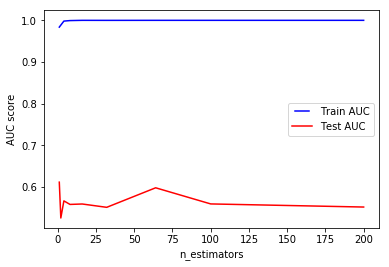

In [86]:
n_estimators = [1, 2, 4, 8, 16, 32, 64, 100, 200]
train_results = []
test_results = []
for estimator in n_estimators:
    rf = RandomForestClassifier(n_estimators=estimator, n_jobs=-1)
    rf.fit(X_train_res, y_train_res)
    train_pred = rf.predict(X_train_res)
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train_res, train_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    train_results.append(roc_auc)
    y_pred = rf.predict(X_test)
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    test_results.append(roc_auc)
from matplotlib.legend_handler import HandlerLine2D
line1, = plt.plot(n_estimators, train_results, 'b', label='Train AUC')
line2, = plt.plot(n_estimators, test_results, 'r', label='Test AUC')
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel('AUC score')
plt.xlabel('n_estimators')
plt.show()

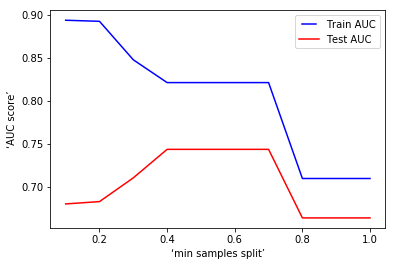

In [88]:
min_samples_splits = np.linspace(0.1, 1.0, 10, endpoint=True)
train_results = []
test_results = []
for min_samples_split in min_samples_splits:
    dt = DecisionTreeClassifier(min_samples_split=min_samples_split)
    dt.fit(X_train_res, y_train_res)
    train_pred = dt.predict(X_train_res)
    false_positive_rate, true_positive_rate, thresholds =    roc_curve(y_train_res, train_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    train_results.append(roc_auc)
    y_pred = dt.predict(X_test)
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    test_results.append(roc_auc)
from matplotlib.legend_handler import HandlerLine2D
line1, = plt.plot(min_samples_splits, train_results, 'b', label='Train AUC')
line2, = plt.plot(min_samples_splits, test_results, 'r', label='Test AUC')
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel('‘AUC score’')
plt.xlabel('‘min samples split’')
plt.show()

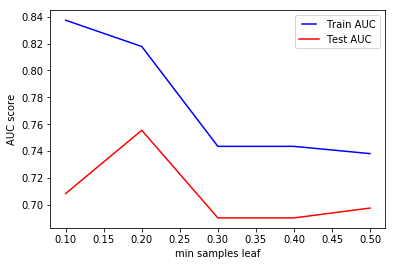

In [89]:
min_samples_leafs = np.linspace(0.1, 0.5, 5, endpoint=True)
train_results = []
test_results = []
for min_samples_leaf in min_samples_leafs:
   dt = DecisionTreeClassifier(min_samples_leaf=min_samples_leaf)
   dt.fit(X_train_res, y_train_res)
   train_pred = dt.predict(X_train_res)
   false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train_res, train_pred)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   train_results.append(roc_auc)
   y_pred = dt.predict(X_test)
   false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   test_results.append(roc_auc)
from matplotlib.legend_handler import HandlerLine2D
line1, = plt.plot(min_samples_leafs, train_results, 'b', label='Train AUC')
line2, = plt.plot(min_samples_leafs, test_results, 'r', label='Test AUC')
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel('AUC score')
plt.xlabel('min samples leaf')
plt.show()

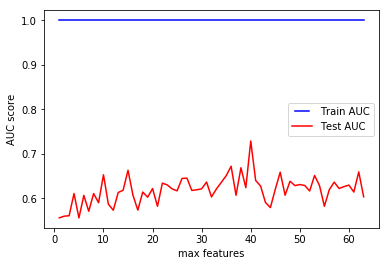

In [91]:
max_features = list(range(1,X_train.shape[1]))
train_results = []
test_results = []
for max_feature in max_features:
    dt = DecisionTreeClassifier(max_features=max_feature)
    dt.fit(X_train_res, y_train_res)
    train_pred = dt.predict(X_train_res)
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train_res, train_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    train_results.append(roc_auc)
    y_pred = dt.predict(X_test)
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    test_results.append(roc_auc)
from matplotlib.legend_handler import HandlerLine2D
line1, = plt.plot(max_features, train_results, 'b', label='Train AUC')
line2, = plt.plot(max_features, test_results, 'r', label='Test AUC')
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel('AUC score')
plt.xlabel('max features')
plt.show()


In [72]:
svm.fit(X_train_res, y_train_res)

/Users/soujanyasamineni/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
    kernel='rbf', max_iter=-1, probability=True, random_state=None,
    shrinking=True, tol=0.001, verbose=False)

In [79]:
prob_svmsvm=svm.predict_proba(X_test)

In [80]:
roc_auc_score(y_test, prob_svmsvm[:,1])

0.8273267200272479

In [37]:
xgb.fit(X_train_res, y_train_res)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [38]:
prob_xgbxgb=xgb.predict_proba(np.asarray(X_test))

In [39]:
roc_auc_score(y_test, prob_xgbxgb[:,1])

0.909972645606267

In [40]:
xgb_2=XGBClassifier(base_score=0.5, booster='dart', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=1000, n_jobs=-1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [41]:
xgb_2.fit(X_train_res, y_train_res)

XGBClassifier(base_score=0.5, booster='dart', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=1000, n_jobs=-1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [42]:
prob_xgbxgb_2=xgb_2.predict_proba(np.asarray(X_test))

In [43]:
roc_auc_score(y_test, prob_xgbxgb_2[:,1])

0.9162125340599455

In [47]:
def objective(space):
    params = {
        'max_depth': int(space['max_depth']),
        'colsample_bytree': space['colsample_bytree'],
        'reg_lambda':space['reg_lambda'],
        'subsample':space['subsample']
    }
    clf = XGBClassifier(n_estimators = 100,learning_rate = 0.1,n_jobs=-1,
                            scale_pos_weight=45.51162790697674, **params)
    clf.fit(X_train_res, y_train_res)
    test_labels_x = clf.predict_proba(np.asarray(X_test))
    try:
        score = roc_auc_score(y_test, test_labels_x[:,1])
    except:
        score = 0.1
    print("PARAMS",params,"SCORE:", score)
    return{'loss':-score, 'status': STATUS_OK }


space ={
        'max_depth':  hp.quniform('max_depth', 5, 12, 1), 
    'colsample_bytree': hp.uniform('colsample_bytree', 0.3, 1.0),
    'subsample':hp.quniform('subsample',0, 1,0.2),
    'reg_lambda': hp.quniform('reg_lambda',0, 5,0.3), 'gamma': hp.quniform('gamma',0, 5,0.3)
    }


trials = Trials()
best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=50,
            trials=trials)

PARAMS                                              
{'max_depth': 5, 'colsample_bytree': 0.8006080370921727, 'reg_lambda': 2.6999999999999997, 'subsample': 0.8}
SCORE:                                              
0.9086368571185286                                  
PARAMS                                                                        
{'max_depth': 7, 'colsample_bytree': 0.7153540292515261, 'reg_lambda': 1.2, 'subsample': 0.6000000000000001}
SCORE:                                                                        
0.8925116016689373                                                            
PARAMS                                                                        
{'max_depth': 8, 'colsample_bytree': 0.9105637650875151, 'reg_lambda': 2.1, 'subsample': 0.8}
SCORE:                                                                        
0.9096134196185286                                                            
PARAMS                                                 

SCORE:                                                                         
0.9288253576294279                                                             
PARAMS                                                                         
{'max_depth': 11, 'colsample_bytree': 0.9968458529272181, 'reg_lambda': 3.5999999999999996, 'subsample': 1.0}
SCORE:                                                                         
0.9288253576294279                                                             
PARAMS                                                                         
{'max_depth': 11, 'colsample_bytree': 0.9942590529018036, 'reg_lambda': 3.9, 'subsample': 1.0}
SCORE:                                                                         
0.9259409059945505                                                             
PARAMS                                                                         
{'max_depth': 9, 'colsample_bytree': 0.8635109351420536, 'reg_lambda': 3.59

In [48]:
best

{'colsample_bytree': 0.9993794791569152,
 'gamma': 1.2,
 'max_depth': 11.0,
 'reg_lambda': 3.5999999999999996,
 'subsample': 1.0}

In [49]:
dt=DecisionTreeClassifier(max_features=None,max_leaf_nodes=1000)

In [50]:
dt.fit(X_train_res, y_train_res)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=1000,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

In [51]:
prob_dt=dt.predict_proba(np.asarray(X_test))

In [52]:
roc_auc_score(y_test, prob_dt[:,1])

0.5655015326975477

In [106]:
bag=BaggingClassifier(base_estimator=rf_2,n_estimators=100,
            max_samples=1.0,bootstrap_features=True)

In [107]:
bag.fit(X_train_res, y_train_res)

BaggingClassifier(base_estimator=RandomForestClassifier(bootstrap=True,
                                                        class_weight={0: 9785,
                                                                      1: 215},
                                                        criterion='gini',
                                                        max_depth=8,
                                                        max_features='auto',
                                                        max_leaf_nodes=None,
                                                        min_impurity_decrease=0.0,
                                                        min_impurity_split=None,
                                                        min_samples_leaf=4,
                                                        min_samples_split=10,
                                                        min_weight_fraction_leaf=0.0,
                                                        n_estimators=

In [108]:
prob_dt_bag=bag.predict_proba(np.asarray(X_test))

In [109]:
roc_auc_score(y_test, prob_dt_bag[:,1])

0.8939990633514986

In [217]:
bstlfy=AdaBoostClassifier(base_estimator=dt,n_estimators=500)

In [218]:
bstlfy.fit(X_train_res, y_train_res)

AdaBoostClassifier(algorithm='SAMME.R',
                   base_estimator=DecisionTreeClassifier(class_weight=None,
                                                         criterion='gini',
                                                         max_depth=None,
                                                         max_features=None,
                                                         max_leaf_nodes=500,
                                                         min_impurity_decrease=0.0,
                                                         min_impurity_split=None,
                                                         min_samples_leaf=1,
                                                         min_samples_split=2,
                                                         min_weight_fraction_leaf=0.0,
                                                         presort=False,
                                                         random_state=None,
                           

In [219]:
prob_dt_adaboost=bstlfy.predict_proba(np.asarray(X_test))

In [220]:
roc_auc_score(y_test, prob_dt_adaboost[:,1])

0.6213811307901907

In [224]:
d_train = lgb.Dataset(X_train_res, label=y_train_res)

In [294]:
params = {}
params['learning_rate'] = 0.1
params['boosting_type'] = 'gbdt'
params['objective'] = 'binary'
params['metric'] = 'auc'
params['sub_feature'] = 0.5
params['num_leaves'] = 70
params['min_data'] = 50
params['max_depth'] = 10
params['feature_fraction']= 0.8,
params['bagging_fraction']= 1,
params['bagging_freq']=10,
params['tree_learner']='serial',
params['min_child_samples']= 20,
params['min_child_weight']= 0.001,
clf = lgb.train(params, d_train, 100)

In [295]:
y_pred=clf.predict(X_test)

In [296]:
roc_auc_score(y_test, y_pred)

0.9347858480926431

In [335]:

final_preds=clf.predict(test_data)

In [339]:
test_result = pd.DataFrame(final_preds, columns = ['class'])
test_result.reset_index(inplace=True)
test_result = test_result.rename(columns={'index':'ID'})
test_result['ID'] +=1
test_result.to_csv('light gbm.csv',index=False)